In [36]:
from Funcs.Utility import *
import numpy as np
import pandas as pd
from typing import Dict, Callable, Union, Tuple, List, Optional, Iterable
from datetime import timedelta as td
from scipy import stats
import ray
import warnings
import time
import ray
import dask

In [37]:
print(PATH_INTERMEDIATE)

/var/nfs_share/Overfitting/D-4/Intermediate


In [38]:
esm_path = os.path.join('Intermediate', 'EsmResponse.csv')

In [39]:
esm_df = pd.read_csv(esm_path)

In [40]:
esm_df

,pcode,intendedTriggerTime,actualTriggerTime,reactionTime,responseTime,happy,relaxed,cheerful,content,sad,anxious,depressed,angry,valence,arousal,stress,disturbance
0,P001,1637718007000,1637718007012,1637718323396,1637718364764,4,4,4,5,2,1,1,1,1,1,1,2
1,P001,1637721522000,1637721522014,1637721539351,1637721569541,4,4,4,5,0,0,0,0,1,1,2,1
2,P001,1637726794000,1637726794012,1637727128306,1637727157539,6,5,6,6,0,0,0,0,3,3,0,6
3,P001,1637731738000,1637731738015,1637731765619,1637731788862,4,4,3,4,1,1,1,0,1,1,2,3
4,P001,1637735113000,1637735113010,1637735123563,1637735144845,5,6,4,5,1,0,0,0,2,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,P135,1641356523000,1641356523009,1641356541930,1641356557520,5,6,6,4,0,0,0,0,2,-3,5,6
21834,P135,1641371411000,1641371412098,1641371431813,1641371448498,5,6,5,4,0,5,1,0,1,-3,4,6
21835,P135,1641375915000,1641375915007,1641375924655,1641375941705,5,6,4,0,0,2,0,0,2,-3,4,4
21836,P135,1641379289000,1641379290110,1641379323048,1641379344457,5,6,6,6,0,2,0,0,1,-3,2,5


In [41]:
esm_df = esm_df[['pcode', 'responseTime', 'stress']]

In [42]:
esm_df

,pcode,responseTime,stress
0,P001,1637718364764,1
1,P001,1637721569541,2
2,P001,1637727157539,0
3,P001,1637731788862,2
4,P001,1637735144845,1
...,...,...,...
21833,P135,1641356557520,5
21834,P135,1641371448498,4
21835,P135,1641375941705,4
21836,P135,1641379344457,2


In [43]:
# Convert responseTime and stress to numeric, coerce errors to NaN
esm_df['responseTime'] = pd.to_numeric(esm_df['responseTime'], errors='coerce')
esm_df['stress'] = pd.to_numeric(esm_df['stress'], errors='coerce')

# Drop rows with NaN values
esm_df.dropna(subset=['responseTime', 'stress'], inplace=True)

/tmp/ipykernel_2289718/4055246896.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  esm_df['responseTime'] = pd.to_numeric(esm_df['responseTime'], errors='coerce')
/tmp/ipykernel_2289718/4055246896.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  esm_df['stress'] = pd.to_numeric(esm_df['stress'], errors='coerce')
/tmp/ipykernel_2289718/4055246896.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

In [44]:
print("NaN values per column:")
print(esm_df.isna().sum())

NaN values per column:
pcode           0
responseTime    0
stress          0
dtype: int64


In [45]:
# Check the unique values of responseTime and stress
print("Unique values in responseTime:", esm_df['responseTime'].unique())
print("Unique values in stress:", esm_df['stress'].unique())

Unique values in responseTime: [1637718364764 1637721569541 1637727157539 ... 1641375941705 1641379344457
 1641384298624]
Unique values in stress: [1 2 0 4 3 6 5]


In [46]:
esm_df.head()

,pcode,responseTime,stress
0,P001,1637718364764,1
1,P001,1637721569541,2
2,P001,1637727157539,0
3,P001,1637731788862,2
4,P001,1637735144845,1


In [47]:
print("Basic Statistics:")
print(esm_df.describe())

Basic Statistics:
       responseTime       stress
count  2.183800e+04  21838.00000
mean   1.639389e+12      2.32851
std    8.768959e+08      1.72344
min    1.637717e+12      0.00000
25%    1.638704e+12      1.00000
50%    1.639368e+12      2.00000
75%    1.640001e+12      4.00000
max    1.641905e+12      6.00000


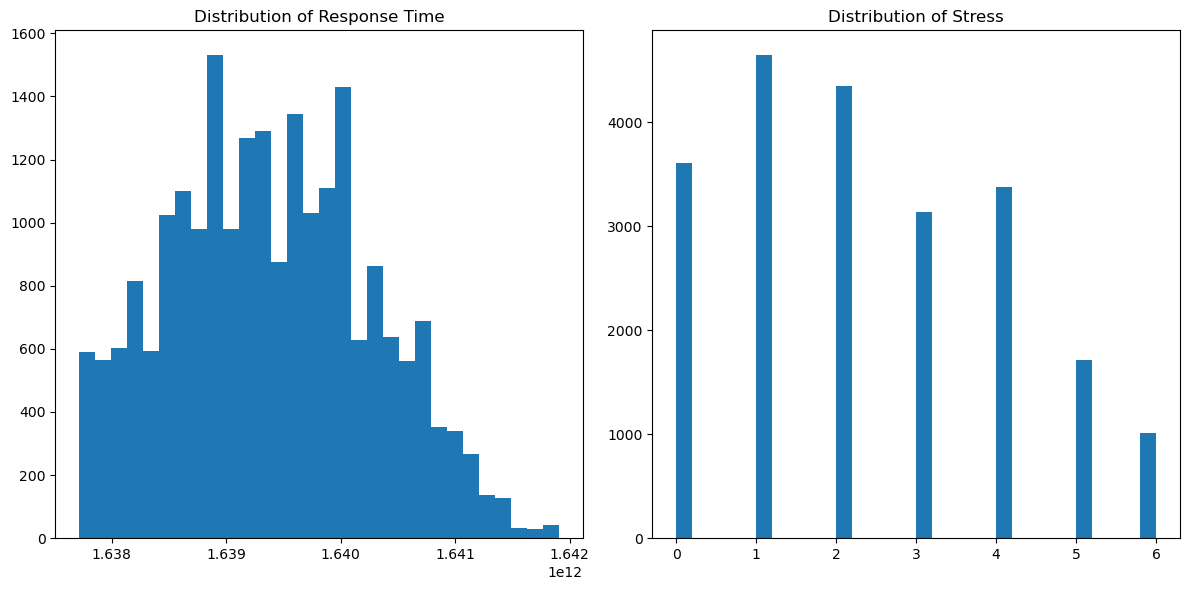

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(esm_df['responseTime'], bins=30)
plt.title('Distribution of Response Time')

plt.subplot(1, 2, 2)
plt.hist(esm_df['stress'], bins=30)
plt.title('Distribution of Stress')

plt.tight_layout()
plt.show()

In [49]:
def calculate_step_count(user_folder, response_time):
    step_file_path = os.path.join(user_folder, 'Fitbit-StepCount.csv')
    if not os.path.exists(step_file_path):
        print(f"File does not exist: {step_file_path}")
        return None

    steps_df = pd.read_csv(step_file_path)
    steps_df['timestamp'] = pd.to_numeric(steps_df['timestamp'], errors='coerce')
    steps_df['value'] = pd.to_numeric(steps_df['value'], errors='coerce')

    start_time = response_time - 30 * 60 * 1000  # 30 minutes before
    end_time = response_time + 30 * 60 * 1000   # 30 minutes after

    # Filter steps within the 1-hour window
    mask = (steps_df['timestamp'] >= start_time) & (steps_df['timestamp'] <= end_time)
    step_count = steps_df.loc[mask, 'value'].sum()

    print(f"User folder: {user_folder}, Response time: {response_time}, Step count: {step_count}")

    return step_count

In [50]:
step_counts = []
for index, row in esm_df.iterrows():
    user_folder = os.path.join(PATH_SENSOR, row['pcode'])
    response_time = row['responseTime']
    step_count = calculate_step_count(user_folder, response_time)
    step_counts.append(step_count)

User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1637718364764, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1637721569541, Step count: 867
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1637727157539, Step count: 632
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1637731788862, Step count: 291
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1637735144845, Step count: 286
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1637738679285, Step count: 62
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1637741895183, Step count: 392
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1637746467521, Step count: 43
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1637749842040, Step count: 257
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1637804762192, Step count: 1254
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1637807978553, Step co

User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1639111310230, Step count: 1759
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1639114813977, Step count: 368
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1639119528585, Step count: 277
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1639123485458, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1639128526344, Step count: 949
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1639136892300, Step count: 120
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1639201284330, Step count: 102
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1639205522147, Step count: 167
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1639209732755, Step count: 432
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1639214929629, Step count: 113
User folder: /var/nfs_share/D#4/newdata/P001, Response time: 1639219407704, Step 

User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1637929981952, Step count: 57
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1637979210970, Step count: 269
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1637988047751, Step count: 61
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1637991794189, Step count: 444
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1637996110430, Step count: 938
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1638001040999, Step count: 72
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1638003978873, Step count: 3043
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1638007871949, Step count: 333
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1638011465020, Step count: 1022
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1638016183972, Step count: 354
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1638065598709, Step 

User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1638933662913, Step count: 687
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1638938851630, Step count: 185
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1638941959699, Step count: 73
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1638945769967, Step count: 223
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1638955918171, Step count: 1552
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1638958602801, Step count: 664
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1638962308501, Step count: 31
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1638967575296, Step count: 2436
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639014760341, Step count: 307
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639018522430, Step count: 873
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639022783015, Step

User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639823428745, Step count: 668
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639826895096, Step count: 771
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639830594627, Step count: 68
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639883280736, Step count: 33
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639888450599, Step count: 431
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639891739127, Step count: 16
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639896448794, Step count: 35
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639901109159, Step count: 77
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639905197181, Step count: 2560
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639909811968, Step count: 43
User folder: /var/nfs_share/D#4/newdata/P002, Response time: 1639913129408, Step coun

User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1638447984358, Step count: 8
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1638500942324, Step count: 1353
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1638504316205, Step count: 34
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1638509089417, Step count: 101
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1638511904685, Step count: 151
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1638515819566, Step count: 344
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1638520710568, Step count: 36
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1638524587264, Step count: 1662
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1638529153264, Step count: 30
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1638534462317, Step count: 565
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1638591050817, Step co

User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1639623703158, Step count: 1263
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1639627533318, Step count: 486
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1639630755236, Step count: 358
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1639633876851, Step count: 529
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1639638355082, Step count: 395
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1639643591985, Step count: 469
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1639647542695, Step count: 541
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1639705624433, Step count: 1249
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1639710100027, Step count: 1512
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1639714781638, Step count: 3276
User folder: /var/nfs_share/D#4/newdata/P003, Response time: 1639717150349, 

User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1638337442010, Step count: 771
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1638340324294, Step count: 371
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1638343854329, Step count: 191
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1638347644315, Step count: 1006
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1638352335443, Step count: 3134
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1638357015131, Step count: 376
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1638361938938, Step count: 103
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1638409009127, Step count: 784
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1638412893890, Step count: 1944
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1638415698277, Step count: 1514
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1638420053318, 

User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1639461292433, Step count: 383
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1639465395879, Step count: 207
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1639468091437, Step count: 521
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1639476712121, Step count: 148
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1639481556966, Step count: 1260
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1639538020017, Step count: 567
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1639548131795, Step count: 29
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1639550983171, Step count: 91
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1639554450116, Step count: 669
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1639559357154, Step count: 311
User folder: /var/nfs_share/D#4/newdata/P007, Response time: 1639562833010, Step 

User folder: /var/nfs_share/D#4/newdata/P008, Response time: 1639626453271, Step count: 627
User folder: /var/nfs_share/D#4/newdata/P008, Response time: 1639631461754, Step count: 1099
User folder: /var/nfs_share/D#4/newdata/P008, Response time: 1639643662580, Step count: 1113
User folder: /var/nfs_share/D#4/newdata/P008, Response time: 1639650777788, Step count: 196
User folder: /var/nfs_share/D#4/newdata/P008, Response time: 1639655679657, Step count: 233
User folder: /var/nfs_share/D#4/newdata/P008, Response time: 1639717620309, Step count: 598
User folder: /var/nfs_share/D#4/newdata/P008, Response time: 1639726597104, Step count: 33
User folder: /var/nfs_share/D#4/newdata/P008, Response time: 1639729977295, Step count: 924
User folder: /var/nfs_share/D#4/newdata/P008, Response time: 1639733212305, Step count: 240
User folder: /var/nfs_share/D#4/newdata/P008, Response time: 1639796352243, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P008, Response time: 1639800263002, Step 

User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1638941794463, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1638945715237, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1638951109001, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1638958522294, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1638966152194, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1639013704004, Step count: 2127
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1639017317028, Step count: 1350
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1639020349350, Step count: 1295
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1639023603151, Step count: 1215
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1639028221038, Step count: 659
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1639037407369, Step count

User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1640483473317, Step count: 12
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1640487995314, Step count: 664
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1640495253934, Step count: 1162
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1640500602581, Step count: 1831
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1640505913216, Step count: 1702
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1640510108725, Step count: 406
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1640513626889, Step count: 48
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1640517426919, Step count: 1289
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1640574514177, Step count: 714
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1640578431921, Step count: 818
User folder: /var/nfs_share/D#4/newdata/P009, Response time: 1640581750032, St

User folder: /var/nfs_share/D#4/newdata/P010, Response time: 1638858953295, Step count: 1578
User folder: /var/nfs_share/D#4/newdata/P010, Response time: 1638867570540, Step count: 377
User folder: /var/nfs_share/D#4/newdata/P010, Response time: 1638871431610, Step count: 390
User folder: /var/nfs_share/D#4/newdata/P010, Response time: 1638876499590, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P010, Response time: 1638881245713, Step count: 396
User folder: /var/nfs_share/D#4/newdata/P010, Response time: 1638933160877, Step count: 14
User folder: /var/nfs_share/D#4/newdata/P010, Response time: 1638945903715, Step count: 7
User folder: /var/nfs_share/D#4/newdata/P010, Response time: 1638950576830, Step count: 147
User folder: /var/nfs_share/D#4/newdata/P010, Response time: 1638953850148, Step count: 63
User folder: /var/nfs_share/D#4/newdata/P010, Response time: 1638957853332, Step count: 101
User folder: /var/nfs_share/D#4/newdata/P010, Response time: 1638963055990, Step coun

User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1637815105680, Step count: 3376
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1637820369813, Step count: 61
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1637824340523, Step count: 1583
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1637827581525, Step count: 204
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1637830858346, Step count: 471
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1637835234571, Step count: 138
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1637839002189, Step count: 261
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1637844352089, Step count: 2197
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1637893301385, Step count: 411
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1637896854082, Step count: 495
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1637901457121, St

User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1639309626000, Step count: 174
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1639360950091, Step count: 284
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1639366528467, Step count: 1444
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1639371341170, Step count: 1016
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1639374748110, Step count: 189
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1639383191778, Step count: 123
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1639388155391, Step count: 59
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1639391478359, Step count: 129
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1639396338140, Step count: 18
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1639447837490, Step count: 223
User folder: /var/nfs_share/D#4/newdata/P011, Response time: 1639452972424, Step

User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1638954005666, Step count: 10
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1638959127812, Step count: 237
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1639016064484, Step count: 874
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1639019561292, Step count: 1261
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1639023230096, Step count: 51
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1639026283046, Step count: 91
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1639030688411, Step count: 258
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1639035547535, Step count: 154
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1639045213143, Step count: 625
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1639048737917, Step count: 8
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1639053149828, Step cou

User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1640252458496, Step count: 358
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1640260341595, Step count: 152
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1640312262012, Step count: 538
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1640315805670, Step count: 1091
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1640329425656, Step count: 661
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1640334404079, Step count: 243
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1640343263790, Step count: 80
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1640347040930, Step count: 83
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1640350570373, Step count: 764
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1640396906724, Step count: 589
User folder: /var/nfs_share/D#4/newdata/P013, Response time: 1640401898084, Step 

User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1638257866702, Step count: 272
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1638261965274, Step count: 1015
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1638271029460, Step count: 1173
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1638274910800, Step count: 30
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1638326831253, Step count: 293
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1638331376342, Step count: 850
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1638334851683, Step count: 15
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1638339092899, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1638344640365, Step count: 3
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1638348424848, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1638352625598, Step count

User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1639303971884, Step count: 3408
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1639313214577, Step count: 277
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1639374137078, Step count: 19
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1639382312907, Step count: 325
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1639386981093, Step count: 1118
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1639390713569, Step count: 421
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1639394577545, Step count: 64
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1639399761950, Step count: 818
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1639447329394, Step count: 336
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1639452465389, Step count: 1652
User folder: /var/nfs_share/D#4/newdata/P014, Response time: 1639456393450, Ste

User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1639054303831, Step count: 305
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1639100690447, Step count: 301
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1639121433452, Step count: 371
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1639126146717, Step count: 722
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1639130450700, Step count: 2054
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1639133445674, Step count: 1493
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1639137916630, Step count: 746
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1639186992456, Step count: 113
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1639190786043, Step count: 511
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1639195151758, Step count: 640
User folder: /var/nfs_share/D#4/newdata/P015, Response time: 1639199555276, St

User folder: /var/nfs_share/D#4/newdata/P016, Response time: 1638951791054, Step count: 1097
User folder: /var/nfs_share/D#4/newdata/P016, Response time: 1638956359966, Step count: 1183
User folder: /var/nfs_share/D#4/newdata/P016, Response time: 1638959963944, Step count: 680
User folder: /var/nfs_share/D#4/newdata/P016, Response time: 1638965030564, Step count: 10
User folder: /var/nfs_share/D#4/newdata/P016, Response time: 1639024882235, Step count: 1236
User folder: /var/nfs_share/D#4/newdata/P016, Response time: 1639029034448, Step count: 7
User folder: /var/nfs_share/D#4/newdata/P016, Response time: 1639033935295, Step count: 108
User folder: /var/nfs_share/D#4/newdata/P016, Response time: 1639039101136, Step count: 3326
User folder: /var/nfs_share/D#4/newdata/P016, Response time: 1639042174357, Step count: 887
User folder: /var/nfs_share/D#4/newdata/P016, Response time: 1639045216071, Step count: 165
User folder: /var/nfs_share/D#4/newdata/P016, Response time: 1639050637084, Ste

User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1638015467336, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1638063767785, Step count: 991
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1638072866352, Step count: 1597
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1638079545731, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1638082819781, Step count: 1756
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1638087154973, Step count: 1697
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1638094441785, Step count: 671
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1638101860577, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1638150169442, Step count: 143
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1638162642770, Step count: 99
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1638165857231, Step cou

User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1639451297585, Step count: 259
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1639464095622, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1639471085952, Step count: 268
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1639479396837, Step count: 6
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1639484670187, Step count: 10
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1639537723207, Step count: 2690
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1639541038501, Step count: 188
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1639546350210, Step count: 1145
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1639550545431, Step count: 56
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1639553842855, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P018, Response time: 1639557954592, Step count

User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1638427840722, Step count: 169
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1638432391936, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1638435345941, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1638443804341, Step count: 76
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1638446880519, Step count: 44
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1638496624030, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1638503278138, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1638507165539, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1638510927567, Step count: 252
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1638521659874, Step count: 64
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1638526348092, Step count: 72
Us

User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1639985618872, Step count: 60
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1639988551189, Step count: 10
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1639993513360, Step count: 45
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1640001998089, Step count: 12
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1640066816748, Step count: 164
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1640072125189, Step count: 912
User folder: /var/nfs_share/D#4/newdata/P019, Response time: 1640074845744, Step count: 842
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1637719572478, Step count: 54
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1637720946777, Step count: 141
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1637727134904, Step count: 231
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1637728289541, Step coun

User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1639119617459, Step count: 230
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1639124173225, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1639128367971, Step count: 529
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1639131507588, Step count: 262
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1639135863971, Step count: 2093
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1639140505077, Step count: 3275
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1639188108956, Step count: 193
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1639193369812, Step count: 2350
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1639198374098, Step count: 358
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1639202498648, Step count: 330
User folder: /var/nfs_share/D#4/newdata/P020, Response time: 1639206013320, Ste

User folder: /var/nfs_share/D#4/newdata/P021, Response time: 1638510473270, Step count: 451
User folder: /var/nfs_share/D#4/newdata/P021, Response time: 1638514868974, Step count: 2031
User folder: /var/nfs_share/D#4/newdata/P021, Response time: 1638518917785, Step count: 200
User folder: /var/nfs_share/D#4/newdata/P021, Response time: 1638532416417, Step count: 512
User folder: /var/nfs_share/D#4/newdata/P021, Response time: 1638535671040, Step count: 166
User folder: /var/nfs_share/D#4/newdata/P021, Response time: 1638585793573, Step count: 522
User folder: /var/nfs_share/D#4/newdata/P021, Response time: 1638589222784, Step count: 746
User folder: /var/nfs_share/D#4/newdata/P021, Response time: 1638592892966, Step count: 853
User folder: /var/nfs_share/D#4/newdata/P021, Response time: 1638596777985, Step count: 249
User folder: /var/nfs_share/D#4/newdata/P021, Response time: 1638600935378, Step count: 312
User folder: /var/nfs_share/D#4/newdata/P021, Response time: 1638605438525, Ste

User folder: /var/nfs_share/D#4/newdata/P022, Response time: 1638003647872, Step count: 4
User folder: /var/nfs_share/D#4/newdata/P022, Response time: 1638008080117, Step count: 363
User folder: /var/nfs_share/D#4/newdata/P022, Response time: 1638011943192, Step count: 105
User folder: /var/nfs_share/D#4/newdata/P022, Response time: 1638016738336, Step count: 424
User folder: /var/nfs_share/D#4/newdata/P022, Response time: 1638068552004, Step count: 830
User folder: /var/nfs_share/D#4/newdata/P022, Response time: 1638078216998, Step count: 706
User folder: /var/nfs_share/D#4/newdata/P022, Response time: 1638083655653, Step count: 85
User folder: /var/nfs_share/D#4/newdata/P022, Response time: 1638089839970, Step count: 689
User folder: /var/nfs_share/D#4/newdata/P022, Response time: 1638094567247, Step count: 87
User folder: /var/nfs_share/D#4/newdata/P022, Response time: 1638098570296, Step count: 187
User folder: /var/nfs_share/D#4/newdata/P022, Response time: 1638151776654, Step cou

User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1637805663632, Step count: 483
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1637809995943, Step count: 972
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1637813932736, Step count: 712
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1637823184906, Step count: 802
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1637831318286, Step count: 637
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1637836117122, Step count: 360
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1637840269258, Step count: 59
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1637896237431, Step count: 423
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1637905110673, Step count: 595
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1637908981183, Step count: 22
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1637922035485, Step c

User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1639051487755, Step count: 507
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1639102190801, Step count: 2556
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1639106958453, Step count: 969
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1639111396968, Step count: 375
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1639115237722, Step count: 1195
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1639120037015, Step count: 703
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1639123833796, Step count: 656
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1639127394790, Step count: 721
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1639130133197, Step count: 906
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1639138003305, Step count: 1092
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1639192796729, S

User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1640338742022, Step count: 2101
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1640343603272, Step count: 961
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1640348983618, Step count: 215
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1640398468329, Step count: 688
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1640401500460, Step count: 361
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1640405560250, Step count: 1624
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1640413303605, Step count: 398
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1640421201960, Step count: 1162
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1640424707756, Step count: 82
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1640428309325, Step count: 166
User folder: /var/nfs_share/D#4/newdata/P023, Response time: 1640435407711, St

User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1639539656079, Step count: 419
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1639543914058, Step count: 115
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1639554525661, Step count: 625
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1639558390582, Step count: 274
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1639621516166, Step count: 1882
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1639626027374, Step count: 344
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1639637960160, Step count: 864
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1639645109426, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1639649855423, Step count: 169
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1639653895954, Step count: 874
User folder: /var/nfs_share/D#4/newdata/P024, Response time: 1639658964410, Step 

User folder: /var/nfs_share/D#4/newdata/P025, Response time: 1638242537497, Step count: 2138
User folder: /var/nfs_share/D#4/newdata/P025, Response time: 1638251627512, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P025, Response time: 1638256535278, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P025, Response time: 1638259690347, Step count: 2317
User folder: /var/nfs_share/D#4/newdata/P025, Response time: 1638264787509, Step count: 1258
User folder: /var/nfs_share/D#4/newdata/P025, Response time: 1638269248346, Step count: 3520
User folder: /var/nfs_share/D#4/newdata/P025, Response time: 1638274161580, Step count: 62
User folder: /var/nfs_share/D#4/newdata/P025, Response time: 1638326996524, Step count: 1475
User folder: /var/nfs_share/D#4/newdata/P025, Response time: 1638332201788, Step count: 1757
User folder: /var/nfs_share/D#4/newdata/P025, Response time: 1638336499328, Step count: 117
User folder: /var/nfs_share/D#4/newdata/P025, Response time: 1638339603868, Ste

User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1637747252942, Step count: 229
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1637752236807, Step count: 104
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1637755849920, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1637805403645, Step count: 4
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1637810728549, Step count: 1137
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1637816103871, Step count: 901
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1637819475604, Step count: 847
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1637833614161, Step count: 289
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1637838782530, Step count: 72
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1637842019632, Step count: 54
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1637897023713, Step coun

User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1639130905630, Step count: 9
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1639134215546, Step count: 65
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1639137653595, Step count: 189
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1639187397724, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1639190275210, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1639195138475, Step count: 421
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1639201769459, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1639212009995, Step count: 15
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1639217310181, Step count: 2221
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1639221155933, Step count: 178
User folder: /var/nfs_share/D#4/newdata/P026, Response time: 1639224049873, Step count: 6

User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1638253294374, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1638262227649, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1638269677569, Step count: 394
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1638275293404, Step count: 364
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1638324955509, Step count: 1844
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1638336014750, Step count: 271
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1638340633144, Step count: 425
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1638344140096, Step count: 405
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1638348016268, Step count: 1242
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1638415447332, Step count: 588
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1638422445682, Step c

User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1639811323255, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1639819115910, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1639827025424, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1639878622400, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1639886805908, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1639893980745, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1639905809125, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1639914013289, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1639965676328, Step count: 23
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1639969426384, Step count: 1157
User folder: /var/nfs_share/D#4/newdata/P027, Response time: 1639979965989, Step count: 140
User

User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1638270722245, Step count: 309
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1638275420123, Step count: 6
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1638323081044, Step count: 664
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1638331394336, Step count: 62
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1638353582930, Step count: 151
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1638359020264, Step count: 14
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1638362873216, Step count: 1382
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1638412829045, Step count: 9
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1638417843056, Step count: 28
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1638422974245, Step count: 1390
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1638431568364, Step coun

User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1639644036580, Step count: 144
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1639649464969, Step count: 71
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1639653409360, Step count: 3520
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1639657454049, Step count: 2214
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1639705264712, Step count: 19
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1639709924019, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1639722915848, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1639735884121, Step count: 6
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1639738973290, Step count: 69
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1639743798543, Step count: 459
User folder: /var/nfs_share/D#4/newdata/P028, Response time: 1639791396617, Step count:

User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1639380413565, Step count: 67
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1639386770589, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1639396600761, Step count: 54
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1639447154555, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1639452156130, Step count: 6
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1639456175168, Step count: 132
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1639459873006, Step count: 210
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1639463288018, Step count: 12
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1639466552313, Step count: 65
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1639473174349, Step count: 34
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1639477862153, Step count: 66


User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1640950809004, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1640955494878, Step count: 10
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1641002489025, Step count: 107
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1641007367892, Step count: 67
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1641020233599, Step count: 1331
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1641027479251, Step count: 1724
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1641042450215, Step count: 1110
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1641096476818, Step count: 135
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1641101140560, Step count: 772
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1641106291802, Step count: 10
User folder: /var/nfs_share/D#4/newdata/P029, Response time: 1641115237580, Step c

User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1638699577744, Step count: 559
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1638704390874, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1638708571291, Step count: 8
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1638754955840, Step count: 52
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1638758822856, Step count: 715
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1638764946095, Step count: 144
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1638769033569, Step count: 732
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1638772842946, Step count: 85
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1638777281557, Step count: 179
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1638781822141, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1638785932062, Step count: 

User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1639817782947, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1639826491822, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1639831709924, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1639878815594, Step count: 1341
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1639882594035, Step count: 688
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1639886853131, Step count: 832
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1639890598608, Step count: 26
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1639894095358, Step count: 47
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1639897838447, Step count: 79
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1639900939821, Step count: 291
User folder: /var/nfs_share/D#4/newdata/P030, Response time: 1639912797789, Step count: 

User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1638864620244, Step count: 12
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1638869530403, Step count: 159
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1638873918306, Step count: 4
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1638879197117, Step count: 8
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1638928392436, Step count: 259
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1638933732737, Step count: 354
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1638938036924, Step count: 1267
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1638942019865, Step count: 4
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1638947400328, Step count: 998
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1638951849480, Step count: 3066
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1638956171605, Step coun

User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1640327077185, Step count: 1948
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1640330632546, Step count: 700
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1640335347446, Step count: 460
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1640401401966, Step count: 138
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1640413966415, Step count: 559
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1640418903649, Step count: 27
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1640423827112, Step count: 7
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1640427363027, Step count: 598
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1640432176943, Step count: 2437
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1640495244921, Step count: 1264
User folder: /var/nfs_share/D#4/newdata/P033, Response time: 1640500957642, Step

User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1638607836522, Step count: 51
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1638612069483, Step count: 1000
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1638620347774, Step count: 1206
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1638672699348, Step count: 649
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1638676866773, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1638682090710, Step count: 2328
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1638689793224, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1638693637586, Step count: 41
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1638698386140, Step count: 798
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1638701855713, Step count: 8
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1638706200794, Step coun

User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1639983176874, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1639988440679, Step count: 628
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1639991651006, Step count: 702
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1639995472458, Step count: 6
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1639998515692, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1640003798860, Step count: 44
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1640052219811, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1640069630574, Step count: 132
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1640075058386, Step count: 749
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1640078163203, Step count: 743
User folder: /var/nfs_share/D#4/newdata/P034, Response time: 1640081830534, Step count: 1

User folder: /var/nfs_share/D#4/newdata/P035, Response time: 1638535766605, Step count: 65
User folder: /var/nfs_share/D#4/newdata/P035, Response time: 1638583002382, Step count: 36
User folder: /var/nfs_share/D#4/newdata/P035, Response time: 1638586394025, Step count: 371
User folder: /var/nfs_share/D#4/newdata/P035, Response time: 1638590222761, Step count: 588
User folder: /var/nfs_share/D#4/newdata/P035, Response time: 1638595521348, Step count: 193
User folder: /var/nfs_share/D#4/newdata/P035, Response time: 1638599660762, Step count: 887
User folder: /var/nfs_share/D#4/newdata/P035, Response time: 1638603364616, Step count: 1615
User folder: /var/nfs_share/D#4/newdata/P035, Response time: 1638606495906, Step count: 1555
User folder: /var/nfs_share/D#4/newdata/P035, Response time: 1638611723970, Step count: 1567
User folder: /var/nfs_share/D#4/newdata/P035, Response time: 1638617751773, Step count: 1560
User folder: /var/nfs_share/D#4/newdata/P035, Response time: 1638622233609, St

User folder: /var/nfs_share/D#4/newdata/P037, Response time: 1638103112782, Step count: 56
User folder: /var/nfs_share/D#4/newdata/P037, Response time: 1638155923485, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P037, Response time: 1638159793025, Step count: 1383
User folder: /var/nfs_share/D#4/newdata/P037, Response time: 1638163393643, Step count: 2340
User folder: /var/nfs_share/D#4/newdata/P037, Response time: 1638167912979, Step count: 104
User folder: /var/nfs_share/D#4/newdata/P037, Response time: 1638172383473, Step count: 69
User folder: /var/nfs_share/D#4/newdata/P037, Response time: 1638184462064, Step count: 243
User folder: /var/nfs_share/D#4/newdata/P037, Response time: 1638246181146, Step count: 51
User folder: /var/nfs_share/D#4/newdata/P037, Response time: 1638249795359, Step count: 642
User folder: /var/nfs_share/D#4/newdata/P037, Response time: 1638258767752, Step count: 225
User folder: /var/nfs_share/D#4/newdata/P037, Response time: 1638264055126, Step co

User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1637924003386, Step count: 3217
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1637928473126, Step count: 437
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1637931576967, Step count: 888
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1637983946070, Step count: 218
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1637988010992, Step count: 1418
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1637992505062, Step count: 1090
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1637996565765, Step count: 2379
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1638001980020, Step count: 1686
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1638006741988, Step count: 116
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1638010663604, Step count: 101
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1638015732190,

User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1638934636321, Step count: 1993
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1638938564010, Step count: 770
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1638942819118, Step count: 775
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1638950990889, Step count: 2097
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1638954349778, Step count: 1350
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1638959094581, Step count: 1146
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1638962337015, Step count: 429
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1638967145684, Step count: 918
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1639016148441, Step count: 99
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1639021031576, Step count: 175
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1639024828817, S

User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1640072002987, Step count: 125
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1640075037800, Step count: 366
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1640079326016, Step count: 1205
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1640082647195, Step count: 1474
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1640085803406, Step count: 3633
User folder: /var/nfs_share/D#4/newdata/P038, Response time: 1640089468419, Step count: 3738
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1637718610574, Step count: 196
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1637732965754, Step count: 16
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1637737591063, Step count: 1082
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1637742426274, Step count: 3142
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1637805410651,

User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1639649109691, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1639654736670, Step count: 3039
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1639705203390, Step count: 434
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1639710018026, Step count: 842
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1639715301799, Step count: 400
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1639719419105, Step count: 19
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1639810657405, Step count: 652
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1639813699025, Step count: 437
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1639817962102, Step count: 1067
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1639896852352, Step count: 966
User folder: /var/nfs_share/D#4/newdata/P040, Response time: 1639900146600, Step 

User folder: /var/nfs_share/D#4/newdata/P041, Response time: 1639018037074, Step count: 14
User folder: /var/nfs_share/D#4/newdata/P041, Response time: 1639021948238, Step count: 1684
User folder: /var/nfs_share/D#4/newdata/P041, Response time: 1639026701395, Step count: 1621
User folder: /var/nfs_share/D#4/newdata/P041, Response time: 1639031845683, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P041, Response time: 1639039881978, Step count: 4
User folder: /var/nfs_share/D#4/newdata/P041, Response time: 1639043150127, Step count: 1895
User folder: /var/nfs_share/D#4/newdata/P041, Response time: 1639051376146, Step count: 202
User folder: /var/nfs_share/D#4/newdata/P041, Response time: 1639106043217, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P041, Response time: 1639109281997, Step count: 180
User folder: /var/nfs_share/D#4/newdata/P041, Response time: 1639114681862, Step count: 164
User folder: /var/nfs_share/D#4/newdata/P041, Response time: 1639118594655, Step cou

User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1637991747013, Step count: 221
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1637995313043, Step count: 13
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1638003902885, Step count: 1633
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1638008043319, Step count: 704
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1638012939031, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1638063490708, Step count: 118
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1638067896056, Step count: 9
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1638073107877, Step count: 1395
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1638081900747, Step count: 1321
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1638089499366, Step count: 382
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1638094420171, Step c

User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1639125882672, Step count: 1277
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1639128998283, Step count: 162
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1639132758233, Step count: 624
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1639140413858, Step count: 92
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1639187263916, Step count: 128
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1639190476602, Step count: 60
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1639193907842, Step count: 270
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1639198863779, Step count: 428
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1639208204311, Step count: 1053
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1639211592086, Step count: 1105
User folder: /var/nfs_share/D#4/newdata/P042, Response time: 1639214971084, Ste

User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1637905075564, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1637915205080, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1637919595884, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1637923915178, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1637929180877, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1637978391216, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1637991298042, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1638011088909, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1638068716409, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1638072725454, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1638082814401, Step count: 0
User folde

User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1639536740853, Step count: 648
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1639540778624, Step count: 392
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1639545816367, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1639560359729, Step count: 434
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1639632784135, Step count: 897
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1639635469560, Step count: 84
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1639639133240, Step count: 420
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1639654964778, Step count: 488
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1639659409256, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1639706521845, Step count: 2048
User folder: /var/nfs_share/D#4/newdata/P043, Response time: 1639710146112, Step cou

User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1637896049353, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1637900962933, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1637904888989, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1637910273247, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1637914326190, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1637921932915, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1637928895569, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1637978358743, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1637982491643, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1637987266714, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1638005040765, Step count: 0
User folde

User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1639364906859, Step count: 82
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1639368673063, Step count: 40
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1639373631074, Step count: 457
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1639377743225, Step count: 24
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1639381355691, Step count: 125
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1639386646529, Step count: 723
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1639391337506, Step count: 31
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1639446565268, Step count: 41
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1639450862426, Step count: 47
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1639463373090, Step count: 153
User folder: /var/nfs_share/D#4/newdata/P044, Response time: 1639467738210, Step count

User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1638264398553, Step count: 998
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1638268259333, Step count: 194
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1638273085507, Step count: 148
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1638323818165, Step count: 20
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1638328508495, Step count: 894
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1638337976887, Step count: 166
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1638341964594, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1638347242407, Step count: 1021
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1638354660020, Step count: 77
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1638359759018, Step count: 125
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1638410819512, Step co

User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1639455016247, Step count: 210
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1639459766087, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1639464629720, Step count: 8
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1639468954467, Step count: 228
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1639473349941, Step count: 1205
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1639478005400, Step count: 48
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1639484452904, Step count: 31
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1639536616128, Step count: 433
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1639541401092, Step count: 1106
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1639546196751, Step count: 430
User folder: /var/nfs_share/D#4/newdata/P045, Response time: 1639550573966, Step cou

User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1638157314701, Step count: 1501
User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1638160138983, Step count: 954
User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1638164799597, Step count: 1220
User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1638173044123, Step count: 2609
User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1638181422872, Step count: 585
User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1638184787108, Step count: 1132
User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1638188147157, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1638238263564, Step count: 73
User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1638242924207, Step count: 43
User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1638246534397, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1638251192775, Step c

User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1640780801436, Step count: 174
User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1640837973005, Step count: 133
User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1640841688868, Step count: 104
User folder: /var/nfs_share/D#4/newdata/P046, Response time: 1640846279222, Step count: 70
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1637722113817, Step count: 1604
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1637727265960, Step count: 1362
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1637732653787, Step count: 92
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1637736622505, Step count: 855
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1637740399572, Step count: 23
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1637744595726, Step count: 136
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1637747792487, Step 

User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1639369984752, Step count: 19
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1639373731993, Step count: 125
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1639377133110, Step count: 37
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1639381614280, Step count: 7
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1639397587848, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1639446651542, Step count: 17
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1639451144633, Step count: 195
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1639456575486, Step count: 1395
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1639463620209, Step count: 1916
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1639468245929, Step count: 27
User folder: /var/nfs_share/D#4/newdata/P047, Response time: 1639472540528, Step count

User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1638237126898, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1638255503677, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1638258889338, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1638267591991, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1638275674347, Step count: 42
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1638323548971, Step count: 1976
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1638328229169, Step count: 11
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1638332055963, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1638336956122, Step count: 2040
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1638341811264, Step count: 7
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1638344911002, Step count: 146


User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1639533798753, Step count: 1274
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1639537043373, Step count: 32
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1639540626303, Step count: 161
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1639549435964, Step count: 22
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1639559096019, Step count: 278
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1639562228993, Step count: 1509
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1639566454755, Step count: 1775
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1639569898490, Step count: 52
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1639619968378, Step count: 158
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1639623367093, Step count: 289
User folder: /var/nfs_share/D#4/newdata/P048, Response time: 1639627089355, Step

User folder: /var/nfs_share/D#4/newdata/P049, Response time: 1638756851302, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P049, Response time: 1638759998255, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P049, Response time: 1638764282950, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P049, Response time: 1638767851507, Step count: 17
User folder: /var/nfs_share/D#4/newdata/P049, Response time: 1638772184019, Step count: 87
User folder: /var/nfs_share/D#4/newdata/P049, Response time: 1638776350059, Step count: 1070
User folder: /var/nfs_share/D#4/newdata/P049, Response time: 1638780586204, Step count: 651
User folder: /var/nfs_share/D#4/newdata/P049, Response time: 1638785781324, Step count: 220
User folder: /var/nfs_share/D#4/newdata/P049, Response time: 1638843855948, Step count: 479
User folder: /var/nfs_share/D#4/newdata/P049, Response time: 1638846394214, Step count: 51
User folder: /var/nfs_share/D#4/newdata/P049, Response time: 1638850692187, Step count: 

User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1638065868570, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1638073281232, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1638078631606, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1638083307163, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1638088133245, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1638092816204, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1638102486543, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1638152432611, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1638155319783, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1638159646126, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1638164987195, Step count: 0
User folde

User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1639380099469, Step count: 18
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1639384659762, Step count: 483
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1639398722421, Step count: 38
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1639447269641, Step count: 147
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1639452264718, Step count: 82
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1639456281595, Step count: 73
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1639461470528, Step count: 388
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1639465771117, Step count: 157
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1639471555279, Step count: 140
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1639476342164, Step count: 249
User folder: /var/nfs_share/D#4/newdata/P050, Response time: 1639480889365, Step cou

User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1638235962668, Step count: 486
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1638240554384, Step count: 1791
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1638253578122, Step count: 145
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1638258424375, Step count: 145
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1638261896044, Step count: 811
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1638271352209, Step count: 733
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1638275640617, Step count: 3108
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1638322726320, Step count: 59
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1638326924182, Step count: 381
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1638331674938, Step count: 34
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1638335509390, Step

User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1639470057215, Step count: 69
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1639473156357, Step count: 1068
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1639476801300, Step count: 553
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1639548769145, Step count: 120
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1639552414295, Step count: 266
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1639570300228, Step count: 783
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1639635523597, Step count: 87
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1639638906097, Step count: 191
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1639642825493, Step count: 1155
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1639649865301, Step count: 976
User folder: /var/nfs_share/D#4/newdata/P051, Response time: 1639654028999, Step

User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1638262915208, Step count: 260
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1638266777783, Step count: 124
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1638270682683, Step count: 94
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1638323854446, Step count: 1544
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1638339627450, Step count: 27
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1638343653776, Step count: 319
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1638347598793, Step count: 513
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1638351397020, Step count: 724
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1638355366323, Step count: 1085
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1638359813400, Step count: 592
User folder: /var/nfs_share/D#4/newdata/P052, Response time: 1638410147505, Step

User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1638668874860, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1638673064137, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1638676369030, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1638680007969, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1638683848036, Step count: 5
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1638700557392, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1638704801772, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1638755745057, Step count: 24
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1638758756840, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1638765752096, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1638775146596, Step count: 0
User fold

User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1639995400280, Step count: 696
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1640004992525, Step count: 10
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1640050074590, Step count: 929
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1640055122186, Step count: 1819
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1640064015849, Step count: 13
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1640068622357, Step count: 319
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1640073414262, Step count: 1349
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1640091941794, Step count: 93
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1640136348363, Step count: 512
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1640141485773, Step count: 774
User folder: /var/nfs_share/D#4/newdata/P054, Response time: 1640151020500, Step 

User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1637999403116, Step count: 1452
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1638002656278, Step count: 1237
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1638011592380, Step count: 105
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1638015967813, Step count: 2181
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1638077274513, Step count: 987
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1638082533659, Step count: 512
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1638085914270, Step count: 191
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1638101776507, Step count: 340
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1638150003226, Step count: 42
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1638154241331, Step count: 629
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1638163525501, St

User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1640143360318, Step count: 289
User folder: /var/nfs_share/D#4/newdata/P055, Response time: 1640150799186, Step count: 227
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1637892406220, Step count: 358
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1637896311603, Step count: 1213
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1637900144050, Step count: 263
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1637905273306, Step count: 260
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1637908930092, Step count: 19
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1637913347586, Step count: 428
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1637917694410, Step count: 546
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1637922944824, Step count: 602
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1637928202531, Step

User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1639034486479, Step count: 1111
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1639042639557, Step count: 274
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1639049955758, Step count: 839
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1639102067188, Step count: 20
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1639105447620, Step count: 994
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1639108991232, Step count: 366
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1639112925442, Step count: 235
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1639120964086, Step count: 207
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1639124965724, Step count: 237
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1639129040370, Step count: 481
User folder: /var/nfs_share/D#4/newdata/P056, Response time: 1639132880771, Step

User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1638013859025, Step count: 220
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1638016955960, Step count: 64
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1638065111027, Step count: 5
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1638068979780, Step count: 5
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1638073320472, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1638077277534, Step count: 13
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1638081990718, Step count: 20
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1638086001751, Step count: 102
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1638090122276, Step count: 10
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1638095362847, Step count: 408
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1638100183167, Step count: 40

User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1639813994280, Step count: 187
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1639818942694, Step count: 94
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1639823397683, Step count: 134
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1639827344887, Step count: 44
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1639830783211, Step count: 216
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1639876818159, Step count: 73
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1639881562241, Step count: 8
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1639885018491, Step count: 389
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1639888188666, Step count: 95
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1639893311947, Step count: 75
User folder: /var/nfs_share/D#4/newdata/P057, Response time: 1639897602261, Step count:

User folder: /var/nfs_share/D#4/newdata/P058, Response time: 1639472996360, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P058, Response time: 1639478949726, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P058, Response time: 1639534503556, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P058, Response time: 1639539072897, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P058, Response time: 1639542693360, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P058, Response time: 1639546085304, Step count: 31
User folder: /var/nfs_share/D#4/newdata/P058, Response time: 1639554671282, Step count: 903
User folder: /var/nfs_share/D#4/newdata/P058, Response time: 1639570184506, Step count: 621
User folder: /var/nfs_share/D#4/newdata/P058, Response time: 1639620613216, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P058, Response time: 1639625397922, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P058, Response time: 1639628406772, Step count: 1174
Us

User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1639459473696, Step count: 1303
User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1639463189918, Step count: 9
User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1639468311722, Step count: 17
User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1639477116430, Step count: 81
User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1639538446938, Step count: 321
User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1639550271733, Step count: 82
User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1639554732567, Step count: 371
User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1639563298844, Step count: 3571
User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1639567073729, Step count: 1111
User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1639619795548, Step count: 358
User folder: /var/nfs_share/D#4/newdata/P059, Response time: 1639624875829, Step c

User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1638954885398, Step count: 3180
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1638958673647, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1638967695015, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1639015403499, Step count: 429
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1639019069657, Step count: 28
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1639023468227, Step count: 9
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1639027503924, Step count: 74
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1639036862929, Step count: 59
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1639041278719, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1639044981202, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1639054082942, Step count: 0
Us

User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1640168020861, Step count: 4777
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1640172971024, Step count: 2975
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1640176626370, Step count: 46
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1640223164644, Step count: 11
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1640227590455, Step count: 100
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1640232388652, Step count: 109
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1640237919680, Step count: 69
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1640241411271, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1640244985105, Step count: 24
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1640249713687, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P061, Response time: 1640259582461, Step count

User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1638758970517, Step count: 1346
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1638762991179, Step count: 312
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1638766613700, Step count: 75
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1638771041914, Step count: 38
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1638775164568, Step count: 48
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1638779876605, Step count: 2054
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1638788405758, Step count: 8
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1638795312684, Step count: 115
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1638842106239, Step count: 338
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1638845377342, Step count: 592
User folder: /var/nfs_share/D#4/newdata/P064, Response time: 1638849393702, Step co

User folder: /var/nfs_share/D#4/newdata/P065, Response time: 1638503204605, Step count: 424
User folder: /var/nfs_share/D#4/newdata/P065, Response time: 1638506756630, Step count: 793
User folder: /var/nfs_share/D#4/newdata/P065, Response time: 1638511727126, Step count: 1226
User folder: /var/nfs_share/D#4/newdata/P065, Response time: 1638520511406, Step count: 846
User folder: /var/nfs_share/D#4/newdata/P065, Response time: 1638525484224, Step count: 223
User folder: /var/nfs_share/D#4/newdata/P065, Response time: 1638530360326, Step count: 41
User folder: /var/nfs_share/D#4/newdata/P065, Response time: 1638534760151, Step count: 159
User folder: /var/nfs_share/D#4/newdata/P065, Response time: 1638583654057, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P065, Response time: 1638587515056, Step count: 57
User folder: /var/nfs_share/D#4/newdata/P065, Response time: 1638590902978, Step count: 1744
User folder: /var/nfs_share/D#4/newdata/P065, Response time: 1638595110712, Step c

User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1638075002455, Step count: 578
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1638078960250, Step count: 610
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1638083834456, Step count: 523
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1638100513501, Step count: 155
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1638103657257, Step count: 4
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1638150574118, Step count: 386
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1638157692338, Step count: 345
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1638161472179, Step count: 434
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1638161546832, Step count: 427
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1638165371394, Step count: 314
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1638174878129, Step c

User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1639883579307, Step count: 140
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1639888374331, Step count: 354
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1639892866487, Step count: 229
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1639901078750, Step count: 17
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1639909063683, Step count: 788
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1639917483602, Step count: 466
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1639974104671, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1639979262644, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1639982813551, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1639987752107, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P066, Response time: 1639991125658, Step count: 0

User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1638417931719, Step count: 190
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1638422536575, Step count: 339
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1638437770644, Step count: 87
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1638497882423, Step count: 706
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1638501484469, Step count: 624
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1638504250653, Step count: 104
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1638508854264, Step count: 143
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1638512854830, Step count: 828
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1638520101332, Step count: 1637
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1638524178685, Step count: 754
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1638529408646, Step

User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1640241647408, Step count: 58
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1640246126060, Step count: 14
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1640249392642, Step count: 12
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1640253135298, Step count: 72
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1640260287833, Step count: 7
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1640316464538, Step count: 276
User folder: /var/nfs_share/D#4/newdata/P067, Response time: 1640321176096, Step count: 165
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1637891817704, Step count: 1591
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1637895355803, Step count: 922
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1637899676327, Step count: 754
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1637903802878, Step coun

User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1639222810314, Step count: 164
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1639227438273, Step count: 1088
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1639273694844, Step count: 1468
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1639284463033, Step count: 48
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1639289050871, Step count: 700
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1639292275534, Step count: 269
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1639305311809, Step count: 4
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1639309836418, Step count: 25
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1639359840445, Step count: 453
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1639362848812, Step count: 1435
User folder: /var/nfs_share/D#4/newdata/P069, Response time: 1639367164668, Step 

User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1638341409880, Step count: 110
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1638345100331, Step count: 247
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1638350083118, Step count: 1020
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1638353100531, Step count: 1718
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1638410453197, Step count: 1497
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1638418824131, Step count: 2559
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1638423231559, Step count: 592
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1638436276388, Step count: 3135
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1638439397342, Step count: 514
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1638444673732, Step count: 1692
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1638448176043

User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1640240810975, Step count: 1569
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1640245793153, Step count: 1315
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1640250161958, Step count: 1162
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1640255882238, Step count: 381
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1640260017356, Step count: 430
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1640309646147, Step count: 1638
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1640315260636, Step count: 1957
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1640318575702, Step count: 7
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1640327354030, Step count: 631
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1640332361839, Step count: 1604
User folder: /var/nfs_share/D#4/newdata/P070, Response time: 1640341747320, 

User folder: /var/nfs_share/D#4/newdata/P071, Response time: 1639793070339, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P071, Response time: 1639796966740, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P071, Response time: 1639799881289, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P071, Response time: 1639803375541, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P071, Response time: 1639812135086, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P071, Response time: 1639816579874, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P071, Response time: 1639878867396, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P071, Response time: 1639886737373, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P071, Response time: 1639889584437, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P071, Response time: 1639894165567, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P071, Response time: 1639898557287, Step count: 0
User folde

User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1638080477657, Step count: 220
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1638085184573, Step count: 43
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1638088957700, Step count: 595
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1638101021622, Step count: 7
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1638154592080, Step count: 282
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1638157781767, Step count: 747
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1638161541516, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1638166767568, Step count: 644
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1638171360504, Step count: 78
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1638175353358, Step count: 1539
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1638236223825, Step coun

User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1639274052572, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1639282719120, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1639287956843, Step count: 65
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1639298500262, Step count: 509
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1639301410307, Step count: 82
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1639309081864, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1639312624597, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1639360436287, Step count: 105
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1639365257534, Step count: 790
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1639369240185, Step count: 400
User folder: /var/nfs_share/D#4/newdata/P072, Response time: 1639379627350, Step count: 0


User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1639131010088, Step count: 2896
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1639136322098, Step count: 1483
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1639141074967, Step count: 182
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1639192078056, Step count: 71
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1639196558560, Step count: 1781
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1639201200689, Step count: 70
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1639204479363, Step count: 94
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1639208409609, Step count: 141
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1639213150191, Step count: 257
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1639222612474, Step count: 1169
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1639227441516, Ste

User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1640914594035, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1640917936848, Step count: 553
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1640921807938, Step count: 1084
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1640927005907, Step count: 750
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1640930930690, Step count: 2712
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1640936503404, Step count: 138
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1640940421661, Step count: 91
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1640945544242, Step count: 179
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1640948996921, Step count: 248
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1640953326732, Step count: 51
User folder: /var/nfs_share/D#4/newdata/P073, Response time: 1641004892796, Step c

User folder: /var/nfs_share/D#4/newdata/P074, Response time: 1640244050644, Step count: 25
User folder: /var/nfs_share/D#4/newdata/P074, Response time: 1640248214087, Step count: 71
User folder: /var/nfs_share/D#4/newdata/P074, Response time: 1640252121244, Step count: 9
User folder: /var/nfs_share/D#4/newdata/P074, Response time: 1640256178786, Step count: 31
User folder: /var/nfs_share/D#4/newdata/P074, Response time: 1640319463504, Step count: 142
User folder: /var/nfs_share/D#4/newdata/P074, Response time: 1640322047865, Step count: 56
User folder: /var/nfs_share/D#4/newdata/P074, Response time: 1640326149691, Step count: 84
User folder: /var/nfs_share/D#4/newdata/P074, Response time: 1640334783175, Step count: 298
User folder: /var/nfs_share/D#4/newdata/P074, Response time: 1640338098717, Step count: 236
User folder: /var/nfs_share/D#4/newdata/P074, Response time: 1640401277459, Step count: 237
User folder: /var/nfs_share/D#4/newdata/P074, Response time: 1640405458463, Step count:

User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1638691338205, Step count: 73
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1638694857113, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1638699111047, Step count: 119
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1638702513494, Step count: 15
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1638756358826, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1638761169311, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1638766182663, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1638770338305, Step count: 22
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1638774643684, Step count: 2113
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1638777814001, Step count: 4420
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1638781604515, Step count: 5

User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1639998668302, Step count: 5
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1640003428293, Step count: 3391
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1640051291834, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1640054699829, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1640058997106, Step count: 123
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1640063987844, Step count: 2532
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1640068258073, Step count: 3865
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1640072242678, Step count: 976
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1640081154083, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1640085135896, Step count: 56
User folder: /var/nfs_share/D#4/newdata/P075, Response time: 1640090087101, Step count

User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1638876814847, Step count: 18
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1638880034681, Step count: 1588
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1638929303503, Step count: 1667
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1638938711706, Step count: 9
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1638942703462, Step count: 294
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1638950271724, Step count: 174
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1638959681257, Step count: 1816
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1638963227354, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1638966380748, Step count: 5
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1639013453514, Step count: 90
User folder: /var/nfs_share/D#4/newdata/P076, Response time: 1639018782044, Step coun

User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1638596649318, Step count: 1946
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1638602315942, Step count: 7
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1638605361886, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1638609476390, Step count: 1649
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1638619505814, Step count: 188
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1638670002993, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1638675261869, Step count: 74
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1638679367868, Step count: 1410
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1638683024778, Step count: 38
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1638688240934, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1638691758177, Step count:

User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1639895722013, Step count: 1162
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1639898795033, Step count: 1207
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1639903785797, Step count: 64
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1639911057235, Step count: 202
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1639915368678, Step count: 6
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1639964758723, Step count: 8
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1639973693264, Step count: 146
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1639978795188, Step count: 324
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1639982099197, Step count: 2156
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1639985200538, Step count: 2108
User folder: /var/nfs_share/D#4/newdata/P077, Response time: 1639993737298, Step 

User folder: /var/nfs_share/D#4/newdata/P078, Response time: 1638784225241, Step count: 404
User folder: /var/nfs_share/D#4/newdata/P078, Response time: 1638788218217, Step count: 252
User folder: /var/nfs_share/D#4/newdata/P078, Response time: 1638792710858, Step count: 399
User folder: /var/nfs_share/D#4/newdata/P078, Response time: 1638841299936, Step count: 995
User folder: /var/nfs_share/D#4/newdata/P078, Response time: 1638844788428, Step count: 142
User folder: /var/nfs_share/D#4/newdata/P078, Response time: 1638849159919, Step count: 244
User folder: /var/nfs_share/D#4/newdata/P078, Response time: 1638853590026, Step count: 292
User folder: /var/nfs_share/D#4/newdata/P078, Response time: 1638856858057, Step count: 174
User folder: /var/nfs_share/D#4/newdata/P078, Response time: 1638860733033, Step count: 122
User folder: /var/nfs_share/D#4/newdata/P078, Response time: 1638865696298, Step count: 708
User folder: /var/nfs_share/D#4/newdata/P078, Response time: 1638937009607, Step

User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1638617818758, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1638622411558, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1638673460667, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1638677347698, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1638681566110, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1638685231612, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1638689796208, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1638692693053, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1638696855311, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1638704219636, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1638756400461, Step count: 0
User folde

User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1639904761695, Step count: 544
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1639912410118, Step count: 649
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1639915859153, Step count: 184
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1639967385296, Step count: 1048
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1639970247837, Step count: 336
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1639975450851, Step count: 403
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1639978668183, Step count: 903
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1639983333496, Step count: 213
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1639986649239, Step count: 555
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1639991154728, Step count: 1081
User folder: /var/nfs_share/D#4/newdata/P079, Response time: 1639994533346, St

User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1638599261261, Step count: 2806
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1638604180453, Step count: 620
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1638608920591, Step count: 315
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1638614043574, Step count: 1387
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1638619298223, Step count: 1016
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1638668039106, Step count: 145
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1638672598310, Step count: 819
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1638676014049, Step count: 594
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1638680052927, Step count: 86
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1638685078491, Step count: 72
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1638689958490, Ste

User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1640331200242, Step count: 1919
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1640334994698, Step count: 1320
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1640345993394, Step count: 4168
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1640349372898, Step count: 1179
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1640398711999, Step count: 1364
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1640403431086, Step count: 4736
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1640406361081, Step count: 4479
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1640410302738, Step count: 4428
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1640413442748, Step count: 3723
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1640425947709, Step count: 485
User folder: /var/nfs_share/D#4/newdata/P081, Response time: 1640430107

User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1638774533359, Step count: 805
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1638785420920, Step count: 75
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1638790649407, Step count: 150
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1638794558417, Step count: 12
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1638842090709, Step count: 52
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1638845911388, Step count: 170
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1638849292085, Step count: 196
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1638854007936, Step count: 2001
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1638856909311, Step count: 2201
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1638860944159, Step count: 262
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1638872039003, Step 

User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1639916009409, Step count: 1595
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1639964450450, Step count: 177
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1639969479634, Step count: 228
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1639973299398, Step count: 4
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1639977731512, Step count: 32
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1639981447362, Step count: 63
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1639984180974, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1639989418565, Step count: 715
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1639993052224, Step count: 136
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1639997386868, Step count: 10
User folder: /var/nfs_share/D#4/newdata/P083, Response time: 1640002089652, Step count

User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1638703378048, Step count: 724
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1638759576586, Step count: 19
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1638763925189, Step count: 198
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1638769128953, Step count: 1741
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1638773261548, Step count: 240
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1638776926191, Step count: 452
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1638780469544, Step count: 138
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1638784668396, Step count: 419
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1638789774994, Step count: 22
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1638845938471, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1638855163984, Step co

User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1640605144285, Step count: 66
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1640660590380, Step count: 598
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1640665073626, Step count: 68
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1640673652005, Step count: 826
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1640678392163, Step count: 2328
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1640691146203, Step count: 1282
User folder: /var/nfs_share/D#4/newdata/P084, Response time: 1640694897649, Step count: 657
User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1638328704050, Step count: 1241
User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1638342190360, Step count: 828
User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1638352079073, Step count: 2094
User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1638355156977, St

User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1639556112459, Step count: 24
User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1639560314492, Step count: 218
User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1639564430881, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1639567792096, Step count: 32
User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1639572844936, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1639620180671, Step count: 10
User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1639623300747, Step count: 58
User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1639633115231, Step count: 68
User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1639636759327, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1639641391714, Step count: 7
User folder: /var/nfs_share/D#4/newdata/P086, Response time: 1639654071266, Step count: 298
U

User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1638684772456, Step count: 25
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1638693326166, Step count: 24
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1638696621489, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1638707152717, Step count: 135
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1638754815257, Step count: 43
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1638762959132, Step count: 979
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1638771332550, Step count: 116
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1638779224418, Step count: 26
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1638782957563, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1638787935909, Step count: 711
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1638793159601, Step count: 

User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1640061014715, Step count: 86
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1640064066526, Step count: 26
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1640067699290, Step count: 3492
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1640082679028, Step count: 170
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1640088116831, Step count: 138
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1640091276682, Step count: 183
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1640138457201, Step count: 30
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1640143224910, Step count: 429
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1640146897812, Step count: 6
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1640150095499, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P087, Response time: 1640159242226, Step count

User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1639047750087, Step count: 227
User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1639102833462, Step count: 654
User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1639109868329, Step count: 428
User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1639114740843, Step count: 472
User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1639121615036, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1639125193837, Step count: 545
User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1639128953798, Step count: 1231
User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1639134321256, Step count: 15
User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1639138653805, Step count: 429
User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1639196893258, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P088, Response time: 1639201117959, Step cou

User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1638772143125, Step count: 1740
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1638776610172, Step count: 30
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1638781231633, Step count: 1321
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1638785503352, Step count: 2806
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1638788586049, Step count: 2283
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1638793118373, Step count: 231
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1638845299762, Step count: 145
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1638849198486, Step count: 31
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1638852256624, Step count: 297
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1638863080377, Step count: 17
User folder: /var/nfs_share/D#4/newdata/P090, Response time: 1638868153176, Ste

User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1638785583621, Step count: 100
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1638789623321, Step count: 35
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1638793490555, Step count: 34
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1638856029332, Step count: 71
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1638859055387, Step count: 4
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1638863561600, Step count: 110
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1638867567129, Step count: 79
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1638872248801, Step count: 137
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1638876073624, Step count: 229
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1638879643293, Step count: 69
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1638937111206, Step count:

User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1640137555240, Step count: 17
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1640148121876, Step count: 118
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1640153267025, Step count: 11
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1640156622400, Step count: 85
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1640166974625, Step count: 143
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1640172005366, Step count: 585
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1640175978569, Step count: 64
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1640234515354, Step count: 73
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1640239735834, Step count: 1277
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1640243680513, Step count: 170
User folder: /var/nfs_share/D#4/newdata/P091, Response time: 1640253685389, Step cou

User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1639217093423, Step count: 80
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1639221548334, Step count: 71
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1639225387072, Step count: 8
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1639283257479, Step count: 54
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1639287966666, Step count: 118
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1639292975718, Step count: 10
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1639296374142, Step count: 49
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1639300362576, Step count: 162
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1639303508331, Step count: 315
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1639307937710, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P092, Response time: 1639312141659, Step count: 8

User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1638522958331, Step count: 203
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1638527901656, Step count: 424
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1638532858250, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1638585789275, Step count: 4
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1638588889831, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1638592080449, Step count: 355
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1638596182347, Step count: 2191
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1638599352372, Step count: 1667
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1638604477524, Step count: 536
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1638609335463, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1638613891557, Step count

User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1641209581226, Step count: 3551
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1641214927984, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1641272161782, Step count: 473
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1641275432285, Step count: 24
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1641283786516, Step count: 476
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1641286964962, Step count: 1055
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1641291851567, Step count: 162
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1641295980745, Step count: 563
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1641300479653, Step count: 9
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1641351162891, Step count: 1541
User folder: /var/nfs_share/D#4/newdata/P094, Response time: 1641354692039, Step c

User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1639392313122, Step count: 942
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1639446652389, Step count: 366
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1639451719363, Step count: 16
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1639457022467, Step count: 89
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1639460042599, Step count: 730
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1639465645111, Step count: 131
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1639473860412, Step count: 269
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1639533053855, Step count: 105
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1639538114074, Step count: 1313
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1639552159811, Step count: 849
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1639556178288, Step 

User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1640846125712, Step count: 102
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1640858740036, Step count: 271
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1640861914157, Step count: 1136
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1640866229465, Step count: 16
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1640916098879, Step count: 2538
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1640920854885, Step count: 310
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1640925899240, Step count: 963
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1640930044513, Step count: 132
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1640932924944, Step count: 12
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1640937181101, Step count: 42
User folder: /var/nfs_share/D#4/newdata/P095, Response time: 1640941035872, Step 

User folder: /var/nfs_share/D#4/newdata/P096, Response time: 1640157979186, Step count: 499
User folder: /var/nfs_share/D#4/newdata/P096, Response time: 1640161082872, Step count: 909
User folder: /var/nfs_share/D#4/newdata/P096, Response time: 1640169636000, Step count: 327
User folder: /var/nfs_share/D#4/newdata/P096, Response time: 1640173371660, Step count: 4
User folder: /var/nfs_share/D#4/newdata/P096, Response time: 1640225860412, Step count: 47
User folder: /var/nfs_share/D#4/newdata/P096, Response time: 1640235021543, Step count: 1317
User folder: /var/nfs_share/D#4/newdata/P096, Response time: 1640240882913, Step count: 1276
User folder: /var/nfs_share/D#4/newdata/P096, Response time: 1640244148741, Step count: 376
User folder: /var/nfs_share/D#4/newdata/P096, Response time: 1640247454525, Step count: 116
User folder: /var/nfs_share/D#4/newdata/P096, Response time: 1640251628309, Step count: 145
User folder: /var/nfs_share/D#4/newdata/P096, Response time: 1640256154168, Step 

User folder: /var/nfs_share/D#4/newdata/P097, Response time: 1641607981493, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P097, Response time: 1641622466394, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P097, Response time: 1641631415245, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P097, Response time: 1641635524540, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P097, Response time: 1641640513115, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P097, Response time: 1641712752291, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P097, Response time: 1641717605944, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P097, Response time: 1641721867938, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P097, Response time: 1641726914551, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P097, Response time: 1641730574097, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P097, Response time: 1641781036600, Step count: 0
User folde

User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1639377428378, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1639381661651, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1639386559755, Step count: 10
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1639390619476, Step count: 1079
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1639394646252, Step count: 85
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1639454216668, Step count: 173
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1639463287242, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1639467971505, Step count: 120
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1639472955674, Step count: 137
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1639476999200, Step count: 1269
User folder: /var/nfs_share/D#4/newdata/P098, Response time: 1639481050242, Step count

User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1638448085389, Step count: 665
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1638495838673, Step count: 9
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1638499271706, Step count: 1773
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1638504214581, Step count: 1508
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1638508773138, Step count: 542
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1638513599379, Step count: 123
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1638518494638, Step count: 486
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1638526867469, Step count: 994
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1638531001832, Step count: 64
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1638534443838, Step count: 567
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1638585668108, Step 

User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1640141673010, Step count: 2245
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1640144707151, Step count: 225
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1640150043382, Step count: 450
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1640154185870, Step count: 519
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1640163352763, Step count: 915
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1640167707370, Step count: 1711
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1640176613713, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1640224058922, Step count: 1098
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1640227791051, Step count: 1822
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1640231209539, Step count: 426
User folder: /var/nfs_share/D#4/newdata/P099, Response time: 1640236486012, St

User folder: /var/nfs_share/D#4/newdata/P101, Response time: 1641709699957, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P101, Response time: 1641714351038, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P101, Response time: 1641725395532, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P101, Response time: 1641791117816, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P101, Response time: 1641796509820, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P101, Response time: 1641805335475, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P101, Response time: 1641811742848, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P101, Response time: 1641877433779, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P101, Response time: 1641882574025, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P101, Response time: 1641892165263, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1638587334842, Step count: 1134
User fo

User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1640327029254, Step count: 47
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1640330730922, Step count: 1196
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1640335571770, Step count: 1334
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1640343031590, Step count: 345
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1640350797138, Step count: 699
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1640397611332, Step count: 1254
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1640405199897, Step count: 631
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1640409926457, Step count: 719
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1640413460344, Step count: 768
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1640421801556, Step count: 648
User folder: /var/nfs_share/D#4/newdata/P102, Response time: 1640425531600, St

User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1639460226117, Step count: 1028
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1639464222272, Step count: 1606
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1639482366512, Step count: 94
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1639534094483, Step count: 1751
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1639537194196, Step count: 2135
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1639540685123, Step count: 316
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1639546487707, Step count: 844
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1639555068904, Step count: 1115
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1639559394486, Step count: 38
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1639563470861, Step count: 157
User folder: /var/nfs_share/D#4/newdata/P103, Response time: 1639568572365, S

User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1638419950169, Step count: 81
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1638422888207, Step count: 93
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1638424316250, Step count: 10
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1638426724575, Step count: 73
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1638434383189, Step count: 591
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1638436589570, Step count: 350
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1638439279073, Step count: 192
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1638441070036, Step count: 259
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1638442422355, Step count: 84
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1638498438869, Step count: 248
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1638506282108, Step coun

User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1639470144823, Step count: 35
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1639473229620, Step count: 9
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1639480960908, Step count: 380
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1639485316924, Step count: 20
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1639536783170, Step count: 770
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1639540332785, Step count: 54
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1639544750812, Step count: 213
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1639571517678, Step count: 116
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1639619223329, Step count: 475
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1639623167599, Step count: 282
User folder: /var/nfs_share/D#4/newdata/P104, Response time: 1639626710370, Step coun

User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1639485384314, Step count: 5
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1639540494953, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1639545284550, Step count: 1243
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1639549311619, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1639552657146, Step count: 8
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1639562954230, Step count: 1305
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1639567005543, Step count: 155
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1639571771981, Step count: 138
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1639626701065, Step count: 6
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1639631635587, Step count: 1498
User folder: /var/nfs_share/D#4/newdata/P105, Response time: 1639635669967, Step count:

User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1639360161372, Step count: 64
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1639363293306, Step count: 995
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1639367302613, Step count: 40
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1639370533336, Step count: 128
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1639375854446, Step count: 19
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1639381037673, Step count: 1069
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1639386380220, Step count: 1363
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1639391060164, Step count: 671
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1639395515980, Step count: 363
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1639399869658, Step count: 215
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1639445772756, Step 

User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1640405416832, Step count: 63
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1640410373376, Step count: 4
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1640414479091, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1640417774738, Step count: 64
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1640421159848, Step count: 6
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1640427692984, Step count: 152
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1640430876386, Step count: 41
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1640484606288, Step count: 101
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1640491776290, Step count: 865
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1640496773402, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P107, Response time: 1640500933968, Step count: 857

User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1638856143237, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1638861077793, Step count: 31
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1638864762024, Step count: 271
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1638874240192, Step count: 895
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1638927784460, Step count: 1072
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1638932445490, Step count: 156
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1638936281301, Step count: 520
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1638939906843, Step count: 14
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1638942535427, Step count: 23
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1638947488390, Step count: 298
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1638955899028, Step cou

User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1640761994851, Step count: 290
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1640767235394, Step count: 115
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1640772602570, Step count: 241
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1640827391399, Step count: 104
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1640835207013, Step count: 175
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1640840135012, Step count: 582
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1640845166140, Step count: 140
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1640849125845, Step count: 405
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1640853715225, Step count: 486
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1640859451329, Step count: 880
User folder: /var/nfs_share/D#4/newdata/P108, Response time: 1640869070291, Step

User folder: /var/nfs_share/D#4/newdata/P109, Response time: 1640486221938, Step count: 2336
User folder: /var/nfs_share/D#4/newdata/P109, Response time: 1640493710369, Step count: 1238
User folder: /var/nfs_share/D#4/newdata/P109, Response time: 1640497151948, Step count: 143
User folder: /var/nfs_share/D#4/newdata/P109, Response time: 1640502502281, Step count: 151
User folder: /var/nfs_share/D#4/newdata/P109, Response time: 1640516961133, Step count: 1383
User folder: /var/nfs_share/D#4/newdata/P109, Response time: 1640520894067, Step count: 816
User folder: /var/nfs_share/D#4/newdata/P109, Response time: 1640576456658, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P109, Response time: 1640603466598, Step count: 113
User folder: /var/nfs_share/D#4/newdata/P109, Response time: 1640607685094, Step count: 386
User folder: /var/nfs_share/D#4/newdata/P109, Response time: 1640654769134, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P109, Response time: 1640658910095, Step 

User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1638931618188, Step count: 560
User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1638935990433, Step count: 1216
User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1638949075597, Step count: 640
User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1638953039847, Step count: 83
User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1638957771470, Step count: 237
User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1638962221031, Step count: 79
User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1638965780008, Step count: 189
User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1639014354220, Step count: 115
User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1639017726458, Step count: 23
User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1639022581587, Step count: 13
User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1639026203709, Step co

User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1641098748306, Step count: 9
User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1641106635169, Step count: 1780
User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1641110553182, Step count: 22
User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1641114806819, Step count: 1633
User folder: /var/nfs_share/D#4/newdata/P110, Response time: 1641126686160, Step count: 1116
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1638856203046, Step count: 283
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1638861348267, Step count: 124
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1638866864578, Step count: 434
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1638871534212, Step count: 240
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1638876834244, Step count: 2805
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1638932847625, Ste

User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1640241884321, Step count: 1020
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1640245659180, Step count: 1331
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1640251142637, Step count: 722
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1640254511758, Step count: 1135
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1640258658137, Step count: 208
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1640314214363, Step count: 38
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1640318308794, Step count: 58
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1640323153177, Step count: 119
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1640327534508, Step count: 1072
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1640332072450, Step count: 360
User folder: /var/nfs_share/D#4/newdata/P114, Response time: 1640336891869, St

User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1638675229260, Step count: 789
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1638679011974, Step count: 561
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1638687205220, Step count: 224
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1638702434125, Step count: 1274
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1638707066595, Step count: 69
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1638761504158, Step count: 608
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1638764852070, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1638778796931, Step count: 50
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1638783037573, Step count: 821
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1638788231470, Step count: 131
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1638791237415, Step co

User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1640743251322, Step count: 247
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1640748435353, Step count: 38
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1640752892140, Step count: 126
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1640757172657, Step count: 303
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1640761656894, Step count: 754
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1640770483676, Step count: 1464
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1640839215318, Step count: 632
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1640843103166, Step count: 1645
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1640915541660, Step count: 1194
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1640920916725, Step count: 799
User folder: /var/nfs_share/D#4/newdata/P115, Response time: 1640925650524, St

User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1639978364713, Step count: 669
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1639982929573, Step count: 111
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1639986059678, Step count: 401
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1639995698513, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1640000551752, Step count: 199
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1640004859373, Step count: 97
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1640072108146, Step count: 10
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1640077137542, Step count: 3344
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1640082336177, Step count: 2426
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1640087608676, Step count: 2477
User folder: /var/nfs_share/D#4/newdata/P116, Response time: 1640090524110, Step 

User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1639304390078, Step count: 6
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1639360122177, Step count: 2285
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1639373799088, Step count: 61
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1639378683711, Step count: 73
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1639386026138, Step count: 391
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1639390780571, Step count: 157
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1639400398262, Step count: 1803
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1639446167761, Step count: 186
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1639455031750, Step count: 60
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1639460587823, Step count: 107
User folder: /var/nfs_share/D#4/newdata/P117, Response time: 1639464732654, Step co

User folder: /var/nfs_share/D#4/newdata/P118, Response time: 1639906221697, Step count: 1469
User folder: /var/nfs_share/D#4/newdata/P118, Response time: 1639913034488, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P118, Response time: 1639964523971, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P118, Response time: 1639973779132, Step count: 193
User folder: /var/nfs_share/D#4/newdata/P118, Response time: 1639976832496, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P118, Response time: 1639980194184, Step count: 1259
User folder: /var/nfs_share/D#4/newdata/P118, Response time: 1639992551195, Step count: 906
User folder: /var/nfs_share/D#4/newdata/P118, Response time: 1639995924877, Step count: 1787
User folder: /var/nfs_share/D#4/newdata/P118, Response time: 1639999341546, Step count: 1189
User folder: /var/nfs_share/D#4/newdata/P118, Response time: 1640004198839, Step count: 450
User folder: /var/nfs_share/D#4/newdata/P118, Response time: 1640050935008, Step c

User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1639542263983, Step count: 162
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1639546232343, Step count: 14
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1639554484054, Step count: 281
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1639559465025, Step count: 1211
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1639565124240, Step count: 678
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1639568435103, Step count: 95
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1639619720806, Step count: 172
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1639623934698, Step count: 242
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1639628736861, Step count: 314
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1639640725059, Step count: 268
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1639651271235, Step 

User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1640923688690, Step count: 658
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1640926887502, Step count: 548
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1640935898121, Step count: 156
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1640941220627, Step count: 496
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1640946469374, Step count: 107
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1640950819619, Step count: 305
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1640954484341, Step count: 515
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1641001617168, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1641006881435, Step count: 102
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1641017243458, Step count: 1405
User folder: /var/nfs_share/D#4/newdata/P119, Response time: 1641027665758, Step 

User folder: /var/nfs_share/D#4/newdata/P120, Response time: 1639965581316, Step count: 54
User folder: /var/nfs_share/D#4/newdata/P120, Response time: 1639970347109, Step count: 952
User folder: /var/nfs_share/D#4/newdata/P120, Response time: 1639973442422, Step count: 321
User folder: /var/nfs_share/D#4/newdata/P120, Response time: 1639976737714, Step count: 101
User folder: /var/nfs_share/D#4/newdata/P120, Response time: 1639981448942, Step count: 108
User folder: /var/nfs_share/D#4/newdata/P120, Response time: 1639987839212, Step count: 1356
User folder: /var/nfs_share/D#4/newdata/P120, Response time: 1640000764572, Step count: 741
User folder: /var/nfs_share/D#4/newdata/P120, Response time: 1640051784691, Step count: 2855
User folder: /var/nfs_share/D#4/newdata/P120, Response time: 1640063027820, Step count: 2529
User folder: /var/nfs_share/D#4/newdata/P120, Response time: 1640087183614, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P120, Response time: 1640143112945, Step

User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1639638155105, Step count: 181
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1639641226189, Step count: 230
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1639645712123, Step count: 586
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1639654970030, Step count: 8
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1639658586666, Step count: 16
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1639706464438, Step count: 493
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1639711081944, Step count: 117
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1639715271298, Step count: 9
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1639720513073, Step count: 138
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1639724643459, Step count: 57
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1639727892637, Step count

User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1640688092299, Step count: 38
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1640692986140, Step count: 9
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1640742849029, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1640746794276, Step count: 17
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1640750683256, Step count: 305
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1640755064243, Step count: 170
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1640758416975, Step count: 26
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1640765826425, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1640770249716, Step count: 512
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1640774505012, Step count: 119
User folder: /var/nfs_share/D#4/newdata/P121, Response time: 1640779044692, Step count: 3

User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1639208641469, Step count: 37
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1639216530143, Step count: 32
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1639221088059, Step count: 85
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1639226310305, Step count: 33
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1639275440548, Step count: 37
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1639280210962, Step count: 26
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1639287210313, Step count: 15
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1639292438142, Step count: 45
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1639295042383, Step count: 29
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1639299767686, Step count: 87
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1639303224953, Step count: 59

User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1640772446280, Step count: 183
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1640777483955, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1640837717639, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1640841042360, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1640851035733, Step count: 99
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1640859003770, Step count: 923
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1640867309441, Step count: 5
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1640921058726, Step count: 2077
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1640924118570, Step count: 1721
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1640927439161, Step count: 49
User folder: /var/nfs_share/D#4/newdata/P122, Response time: 1640932604470, Step count: 

User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1639550362207, Step count: 8
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1639555334563, Step count: 101
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1639563166861, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1639571671143, Step count: 25
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1639645352973, Step count: 508
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1639649619691, Step count: 3106
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1639652821036, Step count: 564
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1639658055685, Step count: 6
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1639710348421, Step count: 10
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1639715259071, Step count: 3291
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1639727845778, Step count

User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1641037073210, Step count: 85
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1641088216346, Step count: 40
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1641091370595, Step count: 463
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1641094645432, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1641099458281, Step count: 222
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1641104067345, Step count: 59
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1641108521507, Step count: 12
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1641118571330, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1641123472896, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P123, Response time: 1641174261700, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1638841641682, Step count: 13
U

User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1641092061044, Step count: 18
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1641095544019, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1641099124095, Step count: 713
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1641103056257, Step count: 94
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1641107736922, Step count: 2368
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1641117173662, Step count: 925
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1641121320217, Step count: 1549
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1641174853145, Step count: 105
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1641178461153, Step count: 79
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1641181958473, Step count: 10
User folder: /var/nfs_share/D#4/newdata/P124, Response time: 1641185528353, Step cou

User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1639542813569, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1639545953780, Step count: 55
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1639553357126, Step count: 15
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1639556528940, Step count: 324
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1639560559511, Step count: 13
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1639625424680, Step count: 1110
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1639629161040, Step count: 1700
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1639639911418, Step count: 999
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1639642901054, Step count: 2379
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1639646915102, Step count: 2920
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1639651164379, Step 

User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1640930399830, Step count: 85
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1640935684051, Step count: 7
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1640939916703, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1640944676793, Step count: 110
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1640947816496, Step count: 140
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1640951729009, Step count: 52
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1640955452422, Step count: 75
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1641003856891, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1641008211341, Step count: 54
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1641012969581, Step count: 269
User folder: /var/nfs_share/D#4/newdata/P125, Response time: 1641016925114, Step count: 16

User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1639891955983, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1639894423371, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1639906921786, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1639910117791, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1639915621698, Step count: 41
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1639918144347, Step count: 223
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1639964600939, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1639968143810, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1639972986147, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1639980564804, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1639984412604, Step count: 182
User 

User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1641185919100, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1641189414208, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1641194845932, Step count: 8
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1641198901421, Step count: 6
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1641203795114, Step count: 2192
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1641208065849, Step count: 1812
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1641212237551, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1641260345891, Step count: 221
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1641265461680, Step count: 974
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1641268354318, Step count: 66
User folder: /var/nfs_share/D#4/newdata/P126, Response time: 1641272296668, Step count: 7

User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1639818652497, Step count: 261
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1639822109176, Step count: 263
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1639829482705, Step count: 616
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1639879380351, Step count: 513
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1639883143388, Step count: 2798
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1639887946896, Step count: 92
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1639893697333, Step count: 4
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1639898478312, Step count: 138
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1639902060858, Step count: 1596
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1639905763067, Step count: 1674
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1639908765515, Step

User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1641371800343, Step count: 1041
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1641376942236, Step count: 543
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1641381004191, Step count: 273
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1641435416527, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P127, Response time: 1641440022842, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P131, Response time: 1639704839598, Step count: 28
User folder: /var/nfs_share/D#4/newdata/P131, Response time: 1639712701596, Step count: 10
User folder: /var/nfs_share/D#4/newdata/P131, Response time: 1639716760887, Step count: 16
User folder: /var/nfs_share/D#4/newdata/P131, Response time: 1639734655209, Step count: 14
User folder: /var/nfs_share/D#4/newdata/P131, Response time: 1639806351900, Step count: 134
User folder: /var/nfs_share/D#4/newdata/P131, Response time: 1639811052160, Step count:

User folder: /var/nfs_share/D#4/newdata/P131, Response time: 1641529307313, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P131, Response time: 1641534913106, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P131, Response time: 1641539754179, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P131, Response time: 1641544049627, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P131, Response time: 1641552030700, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P131, Response time: 1641556278556, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P131, Response time: 1641560211916, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P131, Response time: 1641626187219, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P131, Response time: 1641630426854, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P131, Response time: 1641638663308, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P131, Response time: 1641642245235, Step count: 0
User folde

User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1640052156578, Step count: 2951
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1640058253848, Step count: 1839
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1640061517494, Step count: 25
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1640066782629, Step count: 149
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1640071656591, Step count: 8
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1640075540807, Step count: 505
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1640084042658, Step count: 229
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1640088070645, Step count: 74
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1640138027079, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1640144644087, Step count: 793
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1640147987294, Step cou

User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1641352707501, Step count: 62
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1641355632460, Step count: 978
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1641358852624, Step count: 181
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1641362453083, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1641367289512, Step count: 168
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1641371406879, Step count: 617
User folder: /var/nfs_share/D#4/newdata/P133, Response time: 1641382795118, Step count: 38
User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1638935054226, Step count: 342
User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1638937710128, Step count: 646
User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1638941222091, Step count: 1556
User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1638946396960, Step co

User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1640258181267, Step count: 15
User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1640263407221, Step count: 801
User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1640316059497, Step count: 2501
User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1640319450578, Step count: 783
User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1640323294769, Step count: 1405
User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1640327970960, Step count: 0
User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1640342003503, Step count: 81
User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1640349445473, Step count: 7
User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1640402461335, Step count: 6
User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1640409738040, Step count: 115
User folder: /var/nfs_share/D#4/newdata/P135, Response time: 1640413810287, Step count

In [51]:
esm_df['step_count'] = step_counts

/tmp/ipykernel_2289718/3049517787.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  esm_df['step_count'] = step_counts


In [52]:
print(esm_df)

      pcode   responseTime  stress  step_count
0      P001  1637718364764       1           0
1      P001  1637721569541       2         867
2      P001  1637727157539       0         632
3      P001  1637731788862       2         291
4      P001  1637735144845       1         286
...     ...            ...     ...         ...
21833  P135  1641356557520       5         944
21834  P135  1641371448498       4           0
21835  P135  1641375941705       4           0
21836  P135  1641379344457       2           0
21837  P135  1641384298624       3           0

[21838 rows x 4 columns]


In [53]:
def remove_first_last(df_grouped):
    return df_grouped.iloc[1:-1]

esm_df = esm_df.groupby('pcode').apply(remove_first_last).reset_index(drop=True)

In [54]:
esm_df = esm_df[['pcode', 'responseTime', 'stress', 'step_count']].copy()

# Convert the 'responseTime' column to datetime format without using .loc
esm_df['responseTime'] = pd.to_datetime(esm_df['responseTime'], unit='ms', utc=True).dt.tz_convert(DEFAULT_TZ)

# Display the DataFrame to verify the changes
print(esm_df.head())

  pcode                     responseTime  stress  step_count
0  P001 2021-11-24 11:39:29.541000+09:00       2         867
1  P001 2021-11-24 13:12:37.539000+09:00       0         632
2  P001 2021-11-24 14:29:48.862000+09:00       2         291
3  P001 2021-11-24 15:25:44.845000+09:00       1         286
4  P001 2021-11-24 16:24:39.285000+09:00       0          62


In [55]:
esm_df = esm_df.rename(columns={'responseTime': 'timestamp'})

In [56]:
esm_df 

,pcode,timestamp,stress,step_count
0,P001,2021-11-24 11:39:29.541000+09:00,2,867
1,P001,2021-11-24 13:12:37.539000+09:00,0,632
2,P001,2021-11-24 14:29:48.862000+09:00,2,291
3,P001,2021-11-24 15:25:44.845000+09:00,1,286
4,P001,2021-11-24 16:24:39.285000+09:00,0,62
...,...,...,...,...
21621,P135,2022-01-05 12:00:36.642000+09:00,5,0
21622,P135,2022-01-05 13:22:37.520000+09:00,5,944
21623,P135,2022-01-05 17:30:48.498000+09:00,4,0
21624,P135,2022-01-05 18:45:41.705000+09:00,4,0


In [57]:
# esm_df.to_csv('labels_1h_esmsyn.csv', index=False)

In [58]:
# esm_path = os.path.join('Intermediate', 'labels_1h_esmsyn.csv')
# # df = pd.read_csv(esm_path)

In [59]:
df = esm_df

In [60]:
df

,pcode,timestamp,stress,step_count
0,P001,2021-11-24 11:39:29.541000+09:00,2,867
1,P001,2021-11-24 13:12:37.539000+09:00,0,632
2,P001,2021-11-24 14:29:48.862000+09:00,2,291
3,P001,2021-11-24 15:25:44.845000+09:00,1,286
4,P001,2021-11-24 16:24:39.285000+09:00,0,62
...,...,...,...,...
21621,P135,2022-01-05 12:00:36.642000+09:00,5,0
21622,P135,2022-01-05 13:22:37.520000+09:00,5,944
21623,P135,2022-01-05 17:30:48.498000+09:00,4,0
21624,P135,2022-01-05 18:45:41.705000+09:00,4,0


In [61]:
print("Basic Statistics:")
print(df.describe())

Basic Statistics:
             stress    step_count
count  21626.000000  21626.000000
mean       2.330990    532.986821
std        1.724663    736.073440
min        0.000000      0.000000
25%        1.000000     34.000000
50%        2.000000    214.000000
75%        4.000000    754.000000
max        6.000000   8279.000000


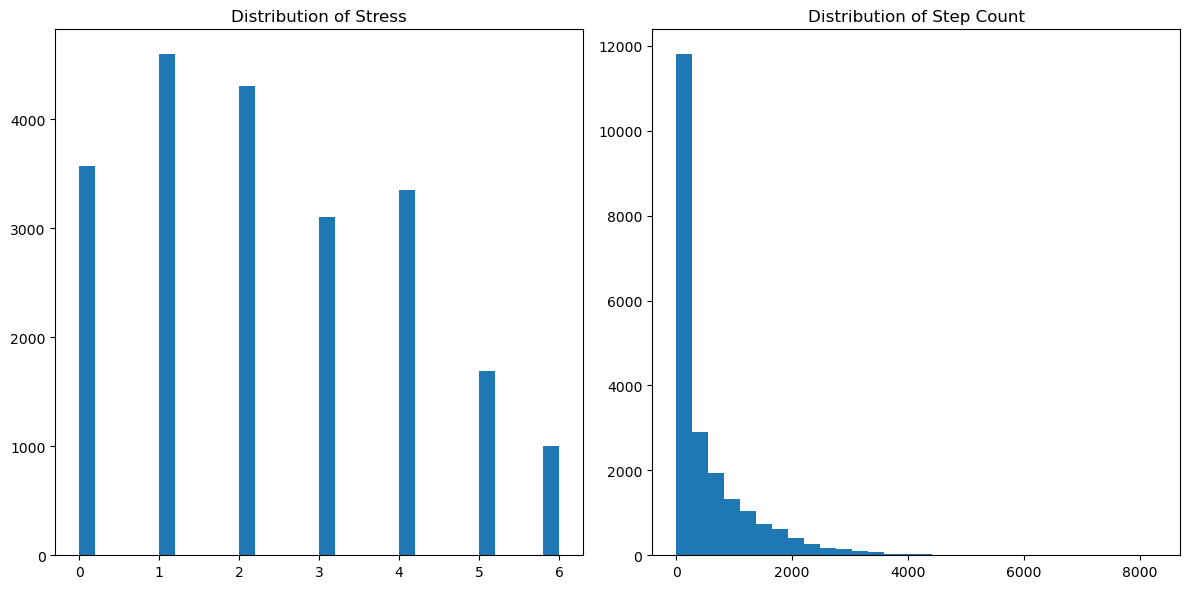

In [62]:
# Simple Matplotlib histograms for distribution plots
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df['stress'], bins=30)
plt.title('Distribution of Stress')

plt.subplot(1, 2, 2)
plt.hist(df['step_count'], bins=30)
plt.title('Distribution of Step Count')

plt.tight_layout()
plt.show()

In [63]:
zero_count = (df['step_count'] == 0).sum()
print(zero_count)

2822


Binarization

In [64]:
# Calculate personal means
personal_means = df.groupby('pcode').mean()[['stress', 'step_count']]

# Calculate overall means
overall_mean_stress = df['stress'].mean()
overall_mean_steps = df['step_count'].mean()

print("Personal Means:")
print(personal_means.head())

print("Overall Mean Stress:", overall_mean_stress)
print("Overall Mean Steps:", overall_mean_steps)

Personal Means:
         stress  step_count
pcode                      
P001   0.653061  465.923469
P002   1.500000  569.306818
P003   3.536290  595.641129
P007   2.700508  559.253807
P008   4.004902  596.642157
Overall Mean Stress: 2.330990474428928
Overall Mean Steps: 532.9868214186628


/tmp/ipykernel_2289718/1453807043.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  personal_means = df.groupby('pcode').mean()[['stress', 'step_count']]


In [65]:
# Function to binarize based on personal means
def binarize_personal(row, personal_means):
    pcode = row['pcode']
    personal_mean_stress = personal_means.loc[pcode, 'stress']
    personal_mean_steps = personal_means.loc[pcode, 'step_count']
    
    row['stress_binary_personal'] = 1 if row['stress'] > personal_mean_stress else 0
    row['step_count_binary_personal'] = 1 if row['step_count'] > personal_mean_steps else 0
    return row

# Binarize based on personal means
df = df.apply(binarize_personal, axis=1, personal_means=personal_means)

# Binarize based on overall means
df['stress_binary_overall'] = df['stress'].apply(lambda x: 1 if x > overall_mean_stress else 0)
df['step_count_binary_overall'] = df['step_count'].apply(lambda x: 1 if x > overall_mean_steps else 0)

# Display the updated DataFrame
print(df.head())


  pcode                        timestamp  stress  step_count  \
0  P001 2021-11-24 11:39:29.541000+09:00       2         867   
1  P001 2021-11-24 13:12:37.539000+09:00       0         632   
2  P001 2021-11-24 14:29:48.862000+09:00       2         291   
3  P001 2021-11-24 15:25:44.845000+09:00       1         286   
4  P001 2021-11-24 16:24:39.285000+09:00       0          62   

   stress_binary_personal  step_count_binary_personal  stress_binary_overall  \
0                       1                           1                      0   
1                       0                           1                      0   
2                       1                           0                      0   
3                       1                           0                      0   
4                       0                           0                      0   

   step_count_binary_overall  
0                          1  
1                          1  
2                          0  
3         

In [66]:
df

,pcode,timestamp,stress,step_count,stress_binary_personal,step_count_binary_personal,stress_binary_overall,step_count_binary_overall
0,P001,2021-11-24 11:39:29.541000+09:00,2,867,1,1,0,1
1,P001,2021-11-24 13:12:37.539000+09:00,0,632,0,1,0,1
2,P001,2021-11-24 14:29:48.862000+09:00,2,291,1,0,0,0
3,P001,2021-11-24 15:25:44.845000+09:00,1,286,1,0,0,0
4,P001,2021-11-24 16:24:39.285000+09:00,0,62,0,0,0,0
...,...,...,...,...,...,...,...,...
21621,P135,2022-01-05 12:00:36.642000+09:00,5,0,1,0,1,0
21622,P135,2022-01-05 13:22:37.520000+09:00,5,944,1,1,1,1
21623,P135,2022-01-05 17:30:48.498000+09:00,4,0,1,0,1,0
21624,P135,2022-01-05 18:45:41.705000+09:00,4,0,1,0,1,0


In [67]:
df = df.drop_duplicates(subset=['pcode', 'timestamp'])

In [68]:
df

,pcode,timestamp,stress,step_count,stress_binary_personal,step_count_binary_personal,stress_binary_overall,step_count_binary_overall
0,P001,2021-11-24 11:39:29.541000+09:00,2,867,1,1,0,1
1,P001,2021-11-24 13:12:37.539000+09:00,0,632,0,1,0,1
2,P001,2021-11-24 14:29:48.862000+09:00,2,291,1,0,0,0
3,P001,2021-11-24 15:25:44.845000+09:00,1,286,1,0,0,0
4,P001,2021-11-24 16:24:39.285000+09:00,0,62,0,0,0,0
...,...,...,...,...,...,...,...,...
21621,P135,2022-01-05 12:00:36.642000+09:00,5,0,1,0,1,0
21622,P135,2022-01-05 13:22:37.520000+09:00,5,944,1,1,1,1
21623,P135,2022-01-05 17:30:48.498000+09:00,4,0,1,0,1,0
21624,P135,2022-01-05 18:45:41.705000+09:00,4,0,1,0,1,0


In [69]:
esm_path = os.path.join('Intermediate', 'labels_1h_esmsyn.csv')
df.to_csv(esm_path, index=False)

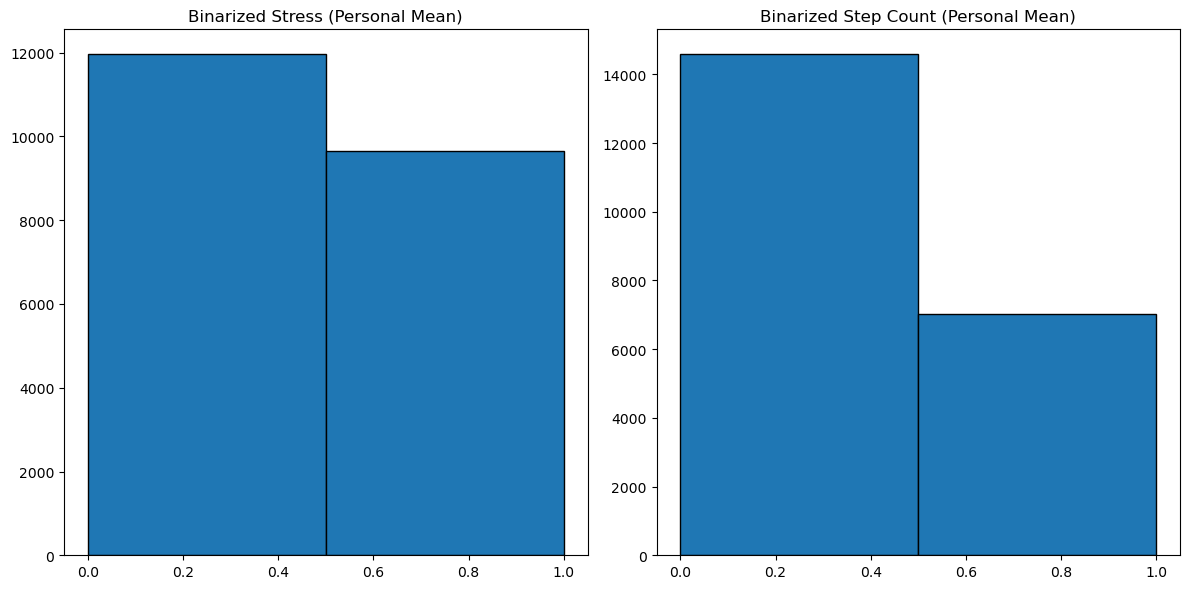

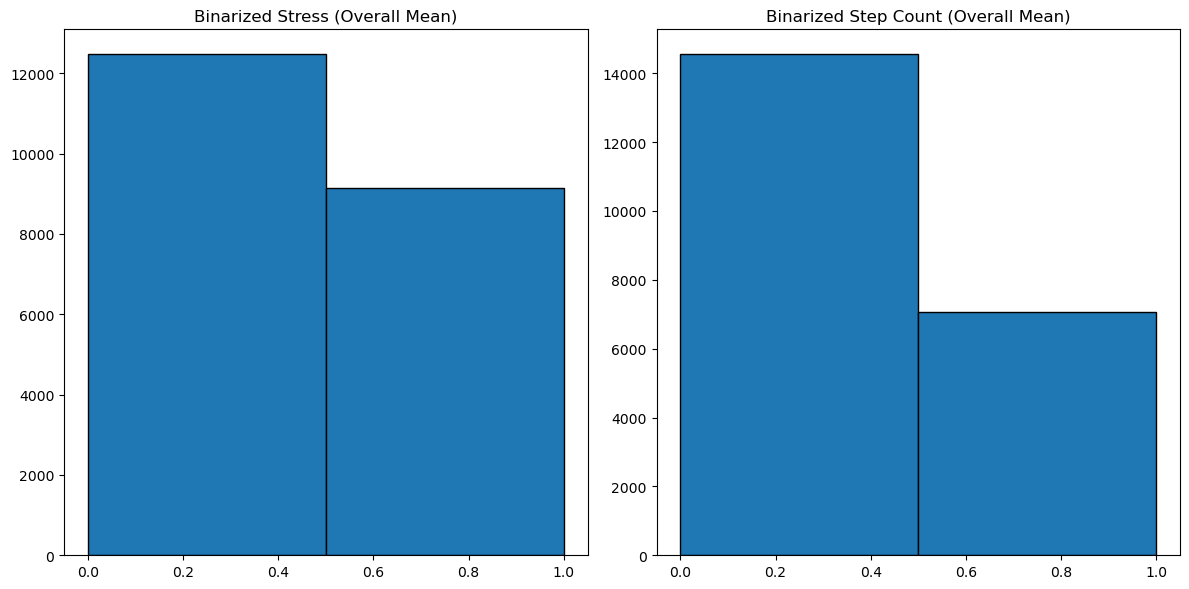

Correlation Matrix (Binarized Data):
                            stress_binary_personal  \
stress_binary_personal                    1.000000   
step_count_binary_personal               -0.060033   
stress_binary_overall                     0.728010   
step_count_binary_overall                -0.055298   

                            step_count_binary_personal  stress_binary_overall  \
stress_binary_personal                       -0.060033               0.728010   
step_count_binary_personal                    1.000000              -0.050424   
stress_binary_overall                        -0.050424               1.000000   
step_count_binary_overall                     0.867351              -0.042305   

                            step_count_binary_overall  
stress_binary_personal                      -0.055298  
step_count_binary_personal                   0.867351  
stress_binary_overall                       -0.042305  
step_count_binary_overall                    1.000000  


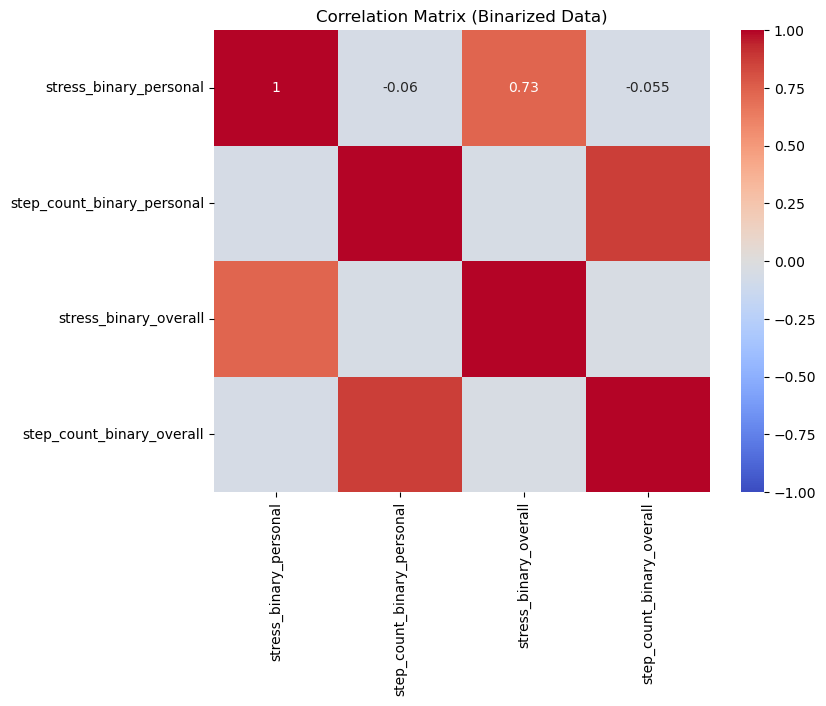

In [70]:
# EDA for Binarized Data

# Distribution plots for personal binarized data using Matplotlib
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df['stress_binary_personal'], bins=2, edgecolor='k')
plt.title('Binarized Stress (Personal Mean)')

plt.subplot(1, 2, 2)
plt.hist(df['step_count_binary_personal'], bins=2, edgecolor='k')
plt.title('Binarized Step Count (Personal Mean)')

plt.tight_layout()
plt.show()

# Distribution plots for overall binarized data using Matplotlib
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df['stress_binary_overall'], bins=2, edgecolor='k')
plt.title('Binarized Stress (Overall Mean)')

plt.subplot(1, 2, 2)
plt.hist(df['step_count_binary_overall'], bins=2, edgecolor='k')
plt.title('Binarized Step Count (Overall Mean)')

plt.tight_layout()
plt.show()

# Correlation analysis for binarized data
correlation_binarized = df[['stress_binary_personal', 'step_count_binary_personal',
                            'stress_binary_overall', 'step_count_binary_overall']].corr()
print("Correlation Matrix (Binarized Data):")
print(correlation_binarized)

# Heatmap for correlation matrix (binarized data) using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_binarized, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix (Binarized Data)')
plt.show()

In [71]:
zero_count = (df['step_count_binary_personal'] == 0).sum()
print(zero_count)

14582


In [72]:
zero_count = (df['step_count_binary_overall'] == 0).sum()
print(zero_count)

14545
